In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, ElasticNet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


### View dataset


In [2]:
# Load data
df = pd.read_csv(r"e:/Nieuw dataset/Joined trends/joined_trend_sales_All1.csv")
df["Periode"] = pd.to_datetime(df["Periode"], format="%Y/%m")
df = df.sort_values("Periode").reset_index(drop=True)

In [3]:
# Bekijk de eerste paar rijen van de dataset en de kolomnamen
print("Kolommen:", df.columns.tolist())
display(df.head())
print("\nAantal rijen:", len(df))
print("\nSamenvatting numerieke kolommen:")
display(df.describe())

Kolommen: ['Periode', 'thuis opladen', 'elektrische auto', 'hybride elektrisch', 'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen', 'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min', 'BenzineEuro95_1_max', 'BenzineEuro95_1_mean', 'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean', 'Totaal_verkochte_wegvoertuigen']


,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtelling (%),Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,BenzineEuro95_1_last,BenzineEuro95_1_min,BenzineEuro95_1_max,BenzineEuro95_1_mean,Diesel_2_first,Diesel_2_last,Diesel_2_min,Diesel_2_max,Diesel_2_mean,Totaal_verkochte_wegvoertuigen
0,2007-01-01,0,1,0,22,20.0,37.0,9.0,8.0,1.318,1.301,1.283,1.326,1.303032,0.992,0.969,0.955,0.993,0.970000,31
1,2007-02-01,0,0,0,22,20.0,37.0,9.0,8.0,1.307,1.362,1.307,1.362,1.325357,0.977,1.003,0.977,1.003,0.990000,39
2,2007-03-01,0,0,0,22,20.0,37.0,9.0,8.0,1.365,1.416,1.361,1.416,1.379032,1.003,1.038,0.995,1.038,1.006323,123
3,2007-04-01,0,0,0,22,20.0,37.0,9.0,8.0,1.414,1.450,1.410,1.451,1.426500,1.036,1.026,1.019,1.039,1.030600,62
4,2007-05-01,0,2,0,22,18.0,32.0,9.0,7.4,1.452,1.463,1.449,1.483,1.466516,1.028,1.037,1.021,1.047,1.032323,84



Aantal rijen: 217

Samenvatting numerieke kolommen:


,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtelling (%),Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,BenzineEuro95_1_last,BenzineEuro95_1_min,BenzineEuro95_1_max,BenzineEuro95_1_mean,Diesel_2_first,Diesel_2_last,Diesel_2_min,Diesel_2_max,Diesel_2_mean,Totaal_verkochte_wegvoertuigen
count,217,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000
mean,2015-12-31 16:15:29.032258048,25.225806,21.718894,14.709677,7.930876,-10.653226,-13.771889,-8.524194,-12.708525,1.653152,1.655553,1.628751,1.680733,1.654974,1.359060,1.361880,1.333535,1.387281,1.360808,6524.239631
min,2007-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,-59.000000,-79.000000,-46.000000,-62.000000,1.161000,1.152000,1.151000,1.245000,1.190774,0.935000,0.930000,0.930000,0.985000,0.960000,31.000000
25%,2011-07-01 00:00:00,0.000000,7.000000,0.000000,4.000000,-26.000000,-46.600000,-15.400000,-24.800000,1.505000,1.508000,1.487000,1.529000,1.511323,1.191000,1.190000,1.166000,1.206000,1.190633,605.000000
50%,2016-01-01 00:00:00,16.000000,13.000000,0.000000,4.000000,-8.000000,-13.250000,-7.500000,-14.200000,1.634000,1.633000,1.613000,1.652000,1.633839,1.341000,1.344000,1.318000,1.370000,1.347935,1447.000000
75%,2020-07-01 00:00:00,51.000000,35.000000,22.000000,14.000000,6.000000,17.000000,1.000000,4.200000,1.767000,1.768000,1.735000,1.777000,1.758100,1.441000,1.441000,1.422000,1.459000,1.437000,10148.000000
max,2025-01-01 00:00:00,100.000000,100.000000,100.000000,22.000000,26.000000,50.000000,12.000000,22.000000,2.318000,2.331000,2.311000,2.383000,2.352700,2.170000,2.179000,2.012000,2.277000,2.142933,39594.000000
std,NaN,27.259380,19.130141,21.220045,6.809567,21.147278,35.425895,13.156476,20.197830,0.205930,0.207252,0.201622,0.210521,0.205612,0.247715,0.249131,0.236212,0.259133,0.247826,9118.838415


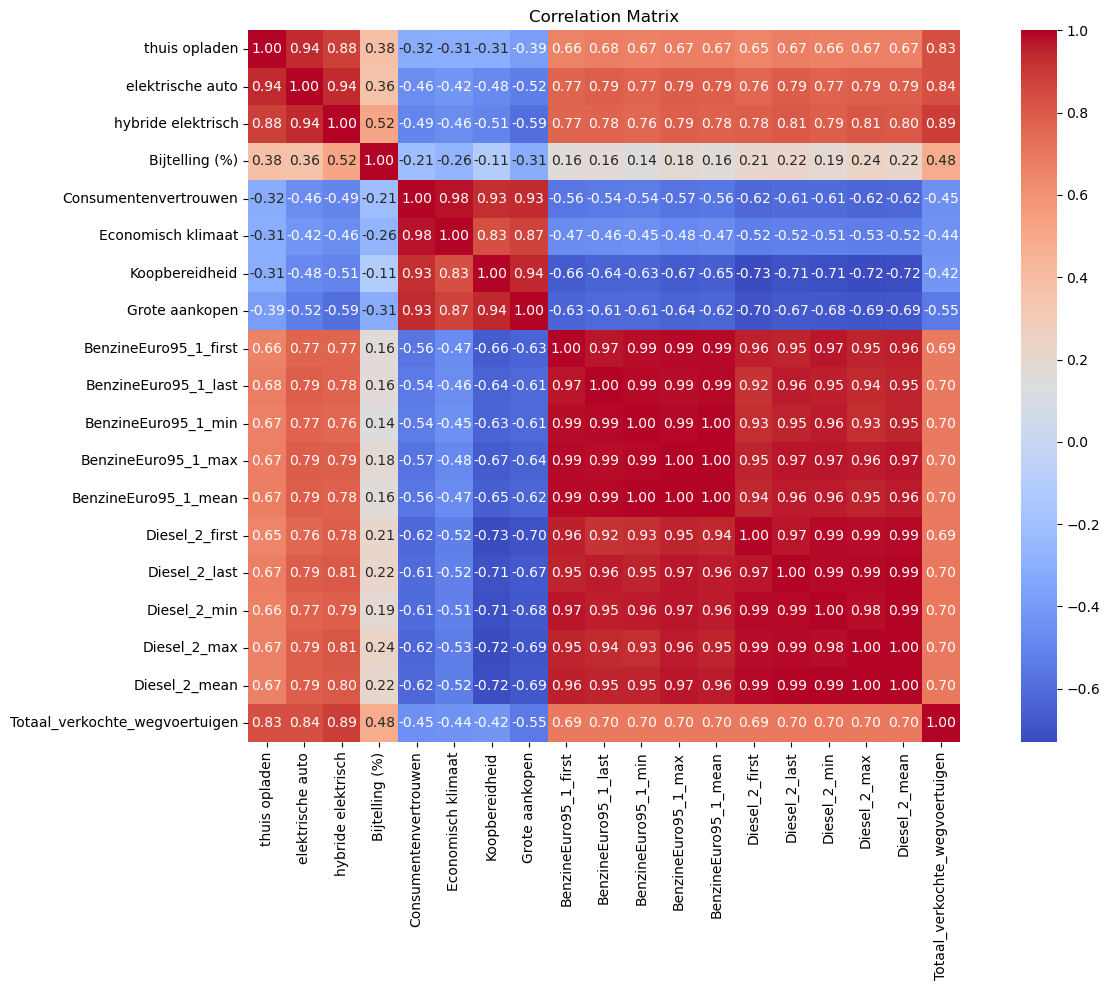

In [4]:
import seaborn as sns

import matplotlib.pyplot as plt

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

#### PCA Test


,Component,Explained Variance Ratio,Cumulative Variance
0,PC1,0.747864,0.747864
1,PC2,0.115663,0.863526
2,PC3,0.077143,0.940669
3,PC4,0.029514,0.970183
4,PC5,0.011062,0.981246
5,PC6,0.006832,0.988077
6,PC7,0.003966,0.992044
7,PC8,0.002819,0.994863
8,PC9,0.002356,0.997219
9,PC10,0.001089,0.998309


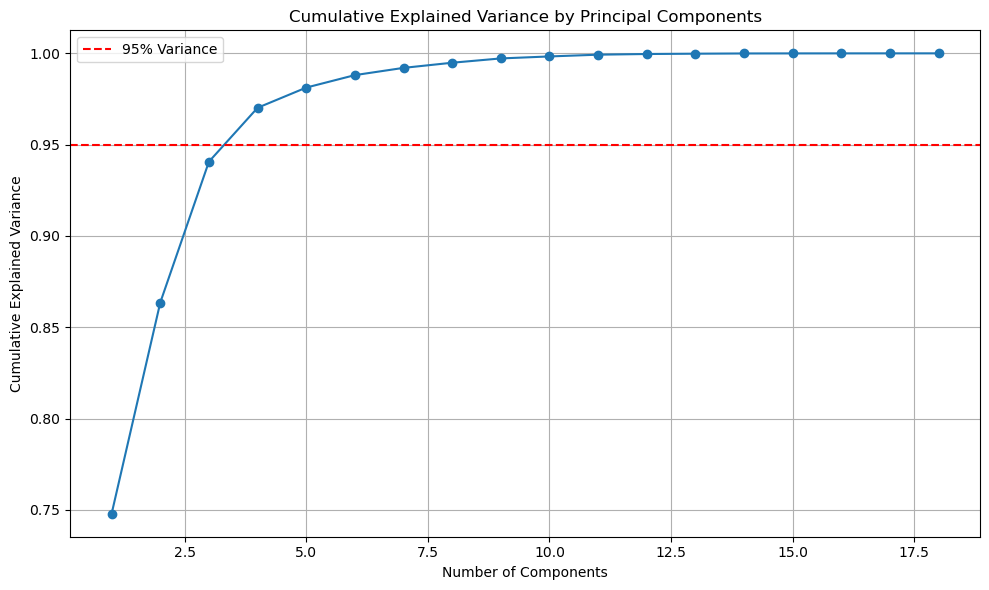

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select only numeric columns (excluding the target if needed)
features = [col for col in numeric_df.columns if col != 'Totaal_verkochte_wegvoertuigen']
X = numeric_df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for explained variance
explained_variance = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Explained Variance Ratio': pca.explained_variance_ratio_,
    'Cumulative Variance': np.cumsum(pca.explained_variance_ratio_)
})

display(explained_variance)

# Plot Scree plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1),
    np.cumsum(pca.explained_variance_ratio_),
    marker='o'
)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.title("Cumulative Explained Variance by Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# Get PCA components (loadings)
loadings = pd.DataFrame(
    pca.components_[:3],  # PC1, PC2, PC3
    columns=X.columns,
    index=['PC1', 'PC2', 'PC3']
)

# Compute combined influence: sum of absolute loadings for PC1-PC3
combined_influence = loadings.abs().sum(axis=0).sort_values(ascending=False)

# Top 5 variables
top5 = combined_influence.head(5)
print("Top 5 variables (PC1-PC3 combined influence):")
print(top5)

Top 5 variables (PC1-PC3 combined influence):
thuis opladen         0.808997
Bijtelling (%)        0.803069
Economisch klimaat    0.788789
Koopbereidheid        0.722995
hybride elektrisch    0.720686
dtype: float64


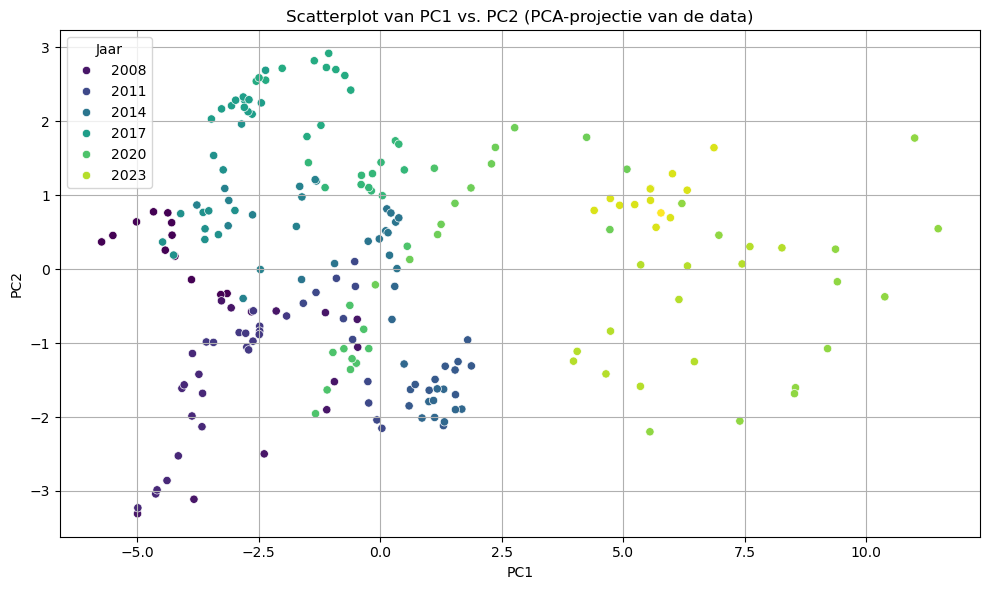

In [9]:
# Create a DataFrame of the first three principal components (scores)
pca_scores = pd.DataFrame(X_pca[:, :3], columns=['PC1', 'PC2', 'PC3'])

# Add date column back if present
if 'Periode' in df.columns:
    pca_scores['Periode'] = pd.to_datetime(df['Periode'])

# Scatterplot PC1 vs PC2
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_scores, hue=pca_scores['Periode'].dt.year if 'Periode' in pca_scores else None, palette='viridis')
plt.title("Scatterplot van PC1 vs. PC2 (PCA-projectie van de data)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend(title="Jaar", loc='best')
plt.tight_layout()
plt.show()

ADF Statistic (Original): 4.4748
p-value: 1.0000
Critical Value 1%: -3.4631
Critical Value 5%: -2.8760
Critical Value 10%: -2.5745
Non-stationary
----------------------------------------
ADF Statistic (Log): -0.7816
p-value: 0.8245
Critical Value 1%: -3.4630
Critical Value 5%: -2.8759
Critical Value 10%: -2.5744
Non-stationary
----------------------------------------
ADF Statistic (Box-Cox (lambda=-0.00)): -0.8076
p-value: 0.8169
Critical Value 1%: -3.4630
Critical Value 5%: -2.8759
Critical Value 10%: -2.5744
Non-stationary
----------------------------------------
ADF Statistic (First Difference): -3.2779
p-value: 0.0159
Critical Value 1%: -3.4630
Critical Value 5%: -2.8759
Critical Value 10%: -2.5744
Stationary
----------------------------------------
ADF Statistic (Log + Diff): -4.1555
p-value: 0.0008
Critical Value 1%: -3.4630
Critical Value 5%: -2.8759
Critical Value 10%: -2.5744
Stationary
----------------------------------------
ADF Statistic (Box-Cox + Diff): -4.1484
p-value: 0

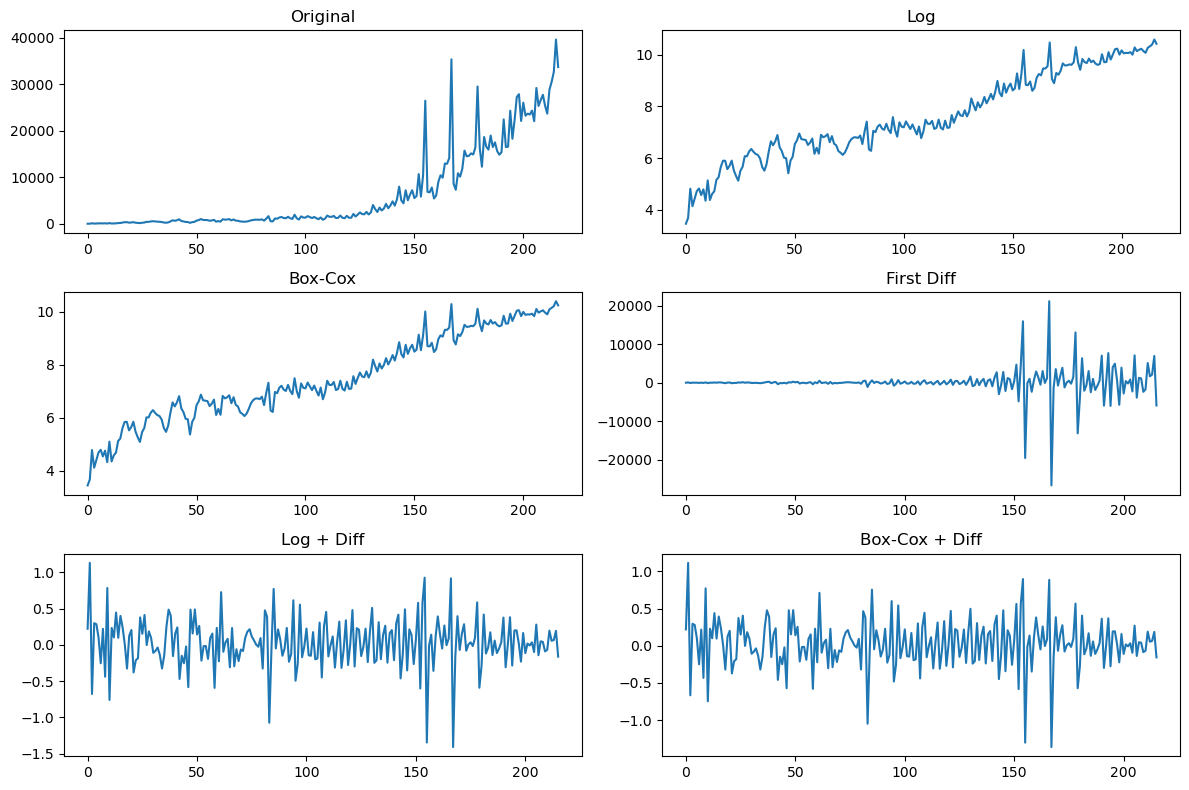

In [10]:
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Select the target series
y = df['Totaal_verkochte_wegvoertuigen'].astype(float).values

def adf_test(series, title=''):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic ({title}): {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value:.4f}')
    print('Stationary' if result[1] < 0.05 else 'Non-stationary')
    print('-'*40)

# 1. Original series
adf_test(y, 'Original')

# 2. Log transformation (add small constant to avoid log(0))
y_log = np.log(y + 1)
adf_test(y_log, 'Log')

# 3. Box-Cox transformation (only for positive values)
y_boxcox, lam = boxcox(y + 1)
adf_test(y_boxcox, f'Box-Cox (lambda={lam:.2f})')

# 4. First difference
y_diff = np.diff(y)
adf_test(y_diff, 'First Difference')

# 5. Log + difference
y_log_diff = np.diff(y_log)
adf_test(y_log_diff, 'Log + Diff')

# 6. Box-Cox + difference
y_boxcox_diff = np.diff(y_boxcox)
adf_test(y_boxcox_diff, 'Box-Cox + Diff')

# Optional: plot all series for visual inspection
plt.figure(figsize=(12, 8))
plt.subplot(3,2,1)
plt.plot(y); plt.title('Original')
plt.subplot(3,2,2)
plt.plot(y_log); plt.title('Log')
plt.subplot(3,2,3)
plt.plot(y_boxcox); plt.title('Box-Cox')
plt.subplot(3,2,4)
plt.plot(y_diff); plt.title('First Diff')
plt.subplot(3,2,5)
plt.plot(y_log_diff); plt.title('Log + Diff')
plt.subplot(3,2,6)
plt.plot(y_boxcox_diff); plt.title('Box-Cox + Diff')
plt.tight_layout()
plt.show()

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler

# Target (stationair maken door differencing)
y = df['Totaal_verkochte_wegvoertuigen'].astype(float)
y_diff = y.diff().dropna()  # d=1

# Exogene variabelen
exog_cols = ['thuis opladen', 'Bijtelling (%)', 'Economisch klimaat', 'Koopbereidheid', 'hybride elektrisch']
X = df[exog_cols].iloc[1:]  # drop first row to match y_diff

# Schaal exogene features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# SARIMAX model (pas p,q aan via AIC/BIC tuning)
model = SARIMAX(
    endog=y_diff,
    exog=X_scaled,
    order=(1, 1, 1),  # p=1, d=1, q=1 als startpunt
    seasonal_order=(0, 0, 0, 0),  # voeg toe als je seizoenspatronen wilt meenemen
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:     Totaal_verkochte_wegvoertuigen   No. Observations:                  216
Model:                           SARIMAX(1, 1, 1)   Log Likelihood               -2090.033
Date:                            Tue, 01 Jul 2025   AIC                           4196.066
Time:                                    14:56:06   BIC                           4222.956
Sample:                                         0   HQIC                          4206.933
                                            - 216                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2086.8742   1251.843     -1.667      0.096   -4540.441     366.692
x2         -9410.4842    540.111   

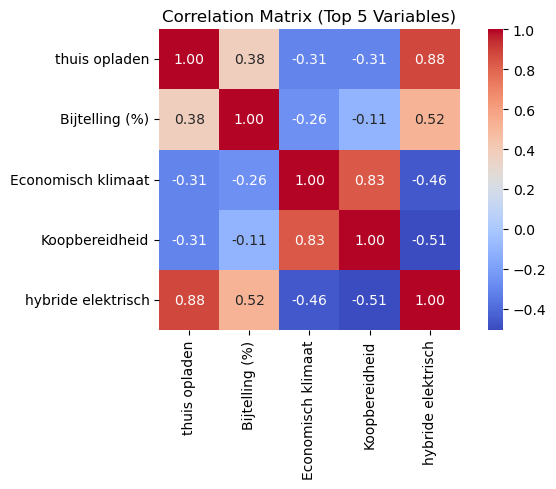

In [12]:
import seaborn as sns

# Select top 5 variable names
top5_vars = top5.index.tolist()

# Compute correlation matrix for top 5 variables
corr_top5 = numeric_df[top5_vars].corr()

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
sns.heatmap(corr_top5, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Top 5 Variables)")
plt.tight_layout()
plt.show()

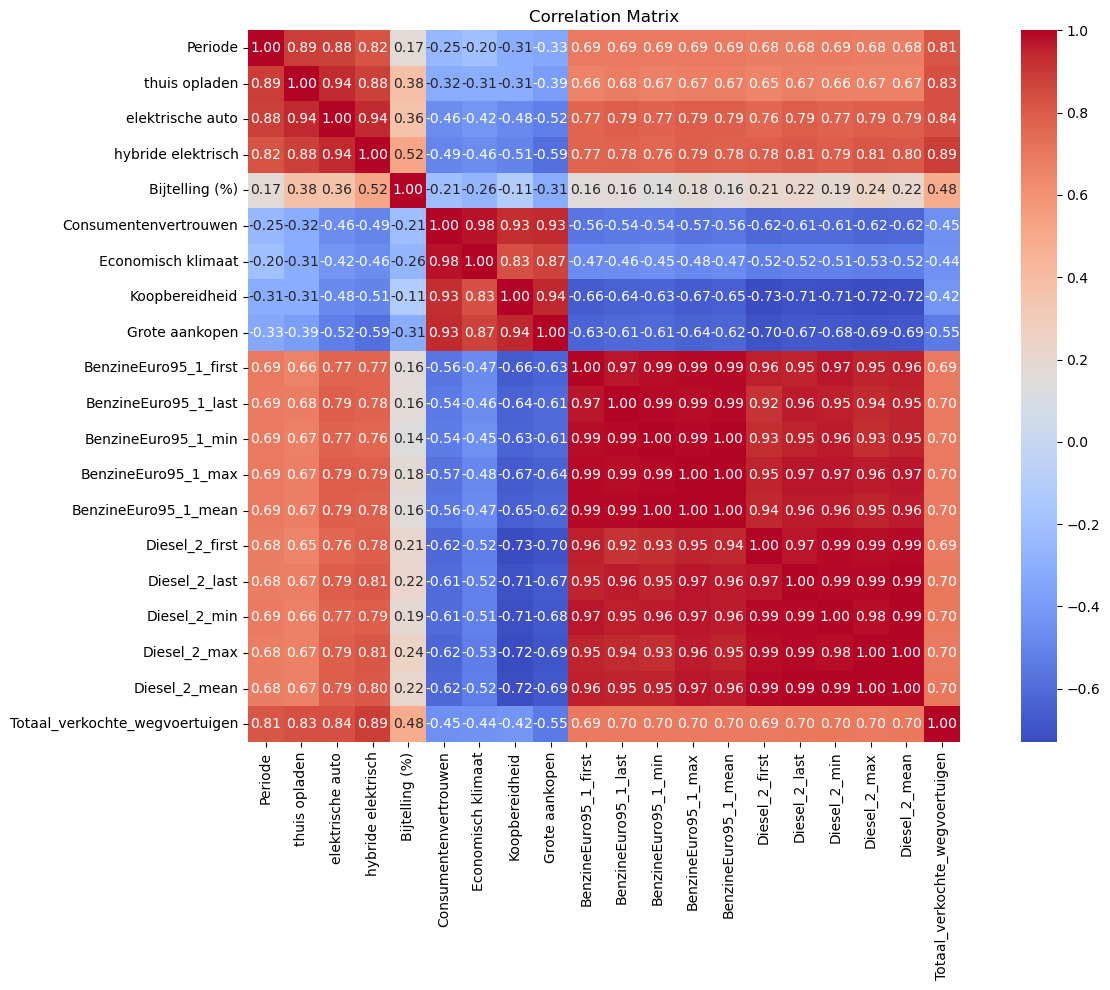

In [11]:
import seaborn as sns

import matplotlib.pyplot as plt

# Compute correlation matrix for all numeric columns
corr_matrix = df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

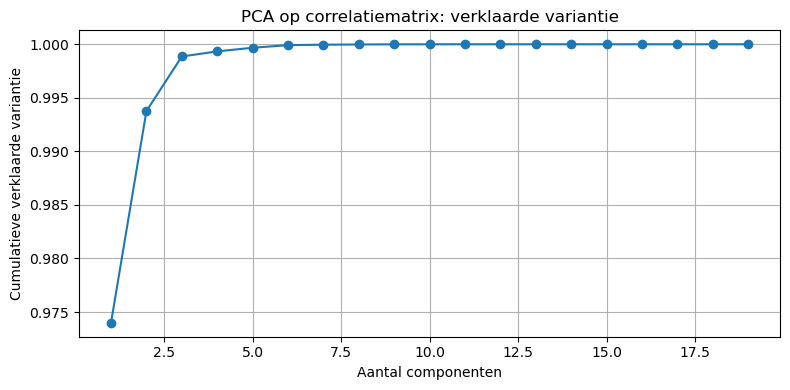

Component 1: verklaarde variantie = 0.9740
Component 2: verklaarde variantie = 0.0198
Component 3: verklaarde variantie = 0.0051
Component 4: verklaarde variantie = 0.0005
Component 5: verklaarde variantie = 0.0003


In [6]:
from sklearn.decomposition import PCA
import numpy as np

import matplotlib.pyplot as plt

# Voer PCA uit op de correlatiematrix
pca = PCA()
pca.fit(corr_matrix)

# Uitlegvariantie per component
explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)

# Plot de cumulatieve verklaarde variantie
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cum_explained_var) + 1), cum_explained_var, marker='o')
plt.xlabel('Aantal componenten')
plt.ylabel('Cumulatieve verklaarde variantie')
plt.title('PCA op correlatiematrix: verklaarde variantie')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print de eerste paar componenten en hun verklaarde variantie
for i, var in enumerate(explained_var[:5], 1):
    print(f"Component {i}: verklaarde variantie = {var:.4f}")

### Speciale nieuwe split 

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# === SARIMAX Wrapper ===
class SARIMAXWrapper:
    def __init__(self, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model_fit = None
        self.scaler = None

    def fit(self, X, y):
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        model = SARIMAX(
            endog=y,
            exog=X_scaled,
            order=self.order,
            seasonal_order=self.seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        self.model_fit = model.fit(disp=False)
        return self

    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model_fit.forecast(steps=len(X_scaled), exog=X_scaled)

# === Expanding Window Validation ===
def strict_expanding_window_validation(
    df, features, target_col, model_fn, forecast_horizon=3
):
    n = len(df)
    test_start = int(n * 0.85)
    val_start = int(n * 0.75)

    X = df[features].values
    y = df[target_col].values

    val_preds, val_actuals, val_dates = [], [], []
    for i in range(val_start, test_start - forecast_horizon + 1):
        X_train = X[:i]
        y_train = y[:i]
        X_val = X[i:i+forecast_horizon]
        y_val = y[i:i+forecast_horizon]

        model = model_fn()
        model.fit(X_train, y_train)
        preds = model.predict(X_val)

        val_preds.extend(preds)
        val_actuals.extend(y_val)
        val_dates.extend(df.iloc[i:i+forecast_horizon]['Periode'].values)

    test_preds, test_actuals, test_dates = [], [], []
    for i in range(test_start, n - forecast_horizon + 1):
        X_train = X[:i]
        y_train = y[:i]
        X_test = X[i:i+forecast_horizon]
        y_test = y[i:i+forecast_horizon]

        model = model_fn()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        test_preds.extend(preds)
        test_actuals.extend(y_test)
        test_dates.extend(df.iloc[i:i+forecast_horizon]['Periode'].values)

    return {
        "val_mae": mean_absolute_error(val_actuals, val_preds),
        "val_rmse": np.sqrt(mean_squared_error(val_actuals, val_preds)),
        "val_r2": r2_score(val_actuals, val_preds),
        "val_mape": mean_absolute_percentage_error(val_actuals, val_preds),
        "val_preds": np.array(val_preds),
        "val_actuals": np.array(val_actuals),
        "val_dates": np.array(val_dates),
        "test_mae": mean_absolute_error(test_actuals, test_preds),
        "test_rmse": np.sqrt(mean_squared_error(test_actuals, test_preds)),
        "test_r2": r2_score(test_actuals, test_preds),
        "test_mape": mean_absolute_percentage_error(test_actuals, test_preds),
        "test_preds": np.array(test_preds),
        "test_actuals": np.array(test_actuals),
        "test_dates": np.array(test_dates)
    }


In [13]:
n = len(df)
train_end = int(n * 0.75)
val_end = int(n * 0.85)
test_end = n

print("Train:")
print(f"  Start: {df['Periode'].iloc[0].strftime('%Y-%m')}")
print(f"  End:   {df['Periode'].iloc[train_end-1].strftime('%Y-%m')}")
print(f"  Size:  {train_end} ({train_end/n:.1%})")

print("\nValidation:")
print(f"  Start: {df['Periode'].iloc[train_end].strftime('%Y-%m')}")
print(f"  End:   {df['Periode'].iloc[val_end-1].strftime('%Y-%m')}")
print(f"  Size:  {val_end-train_end} ({(val_end-train_end)/n:.1%})")

print("\nTest:")
print(f"  Start: {df['Periode'].iloc[val_end].strftime('%Y-%m')}")
print(f"  End:   {df['Periode'].iloc[test_end-1].strftime('%Y-%m')}")
print(f"  Size:  {test_end-val_end} ({(test_end-val_end)/n:.1%})")

Train:
  Start: 2007-01
  End:   2020-06
  Size:  162 (74.7%)

Validation:
  Start: 2020-07
  End:   2022-04
  Size:  22 (10.1%)

Test:
  Start: 2022-05
  End:   2025-01
  Size:  33 (15.2%)


SARIMAX voorspelling voor validatie (komende 3 maanden):
2022-02: 14582
2022-03: 11059
2022-04: 11280

Werkelijke waarden:
2022-02: 12278


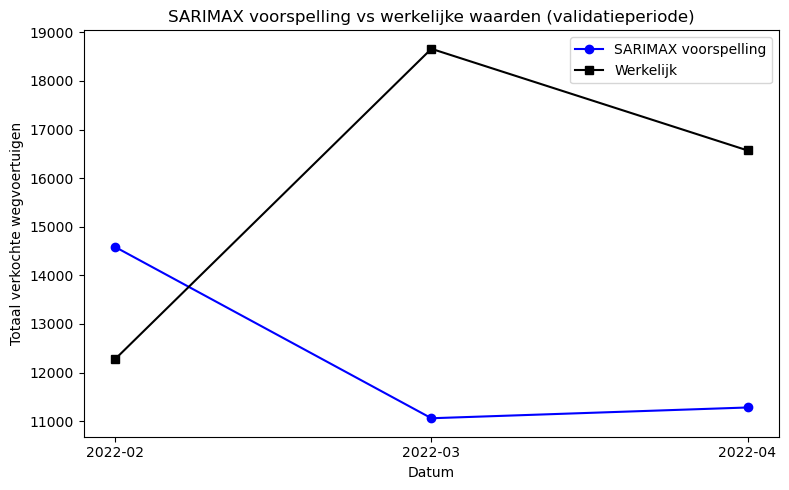

2022-03: 18662


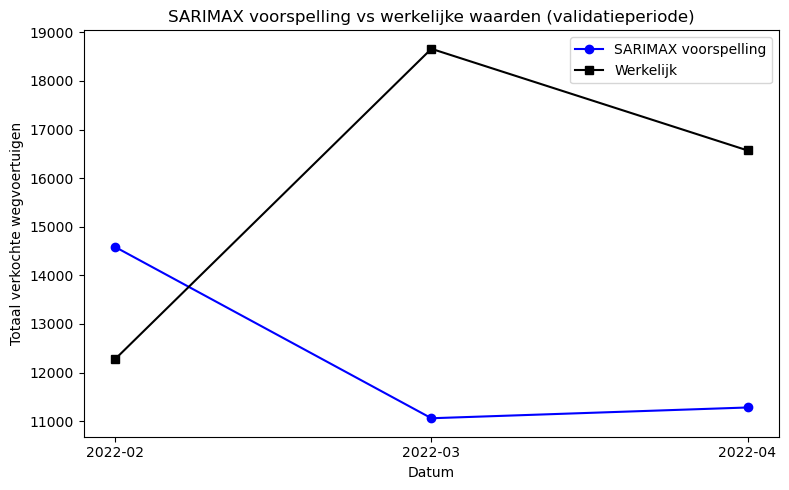

2022-04: 16571


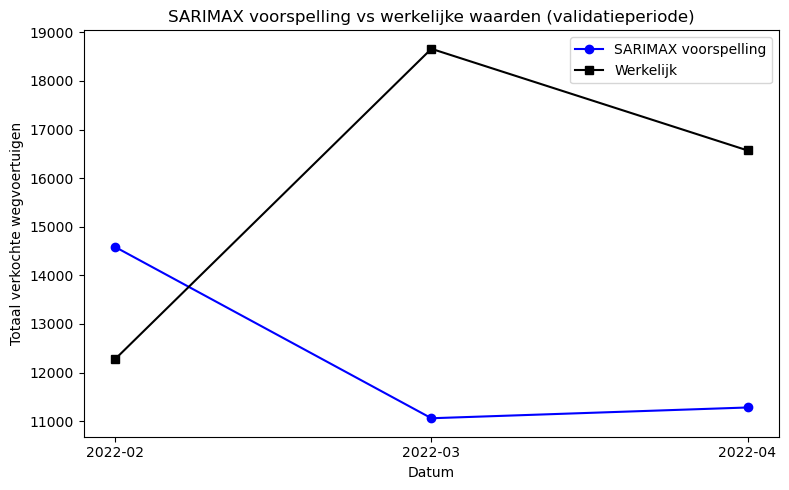

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Gebruik dezelfde exogene kolommen als eerder
exog_cols = ['thuis opladen', 'Bijtelling (%)', 'Economisch klimaat', 'Koopbereidheid', 'hybride elektrisch']

# Target en exog voorbereiden
y = df['Totaal_verkochte_wegvoertuigen'].astype(float)
X = df[exog_cols]

# Split indices (consistent met je splits)
n = len(df)
train_end = int(n * 0.75)
val_end = int(n * 0.85)

# Train op train+val tot net vóór de 3 maanden die je wilt voorspellen
train_idx = val_end - 3  # laatste 3 maanden zijn voor validatie-voorspelling
y_train = y.iloc[:train_idx]
X_train = X.iloc[:train_idx]

# Exog voor de 3 maanden die je wilt voorspellen
X_forecast = X.iloc[train_idx:train_idx+3]

# Schaal exogene variabelen
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_forecast_scaled = scaler.transform(X_forecast)

# SARIMAX model fitten (gebruik dezelfde order als eerder)
model = SARIMAX(
    endog=y_train,
    exog=X_train_scaled,
    order=(1, 1, 1),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

# Voorspel de komende 3 maanden (validatie)
forecast = results.forecast(steps=3, exog=X_forecast_scaled)
forecast = np.array(forecast)

# Toon resultaten
forecast_dates = df['Periode'].iloc[train_idx:train_idx+3].dt.strftime('%Y-%m').tolist()
print("SARIMAX voorspelling voor validatie (komende 3 maanden):")
for d, pred in zip(forecast_dates, forecast):
    print(f"{d}: {pred:.0f}")

# Optioneel: vergelijk met werkelijke waarden indien beschikbaar
actuals = y.iloc[train_idx:train_idx+3].values
print("\nWerkelijke waarden:")
for d, act in zip(forecast_dates, actuals):
    print(f"{d}: {act:.0f}")

    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 5))
    plt.plot(forecast_dates, forecast, marker='o', label='SARIMAX voorspelling', color='blue')
    plt.plot(forecast_dates, actuals, marker='s', label='Werkelijk', color='black')
    plt.title('SARIMAX voorspelling vs werkelijke waarden (validatieperiode)')
    plt.xlabel('Datum')
    plt.ylabel('Totaal verkochte wegvoertuigen')
    plt.legend()
    plt.tight_layout()
    plt.show()


Validation Results:
MAPE: 0.2080
MAE : 2972.46
RMSE: 4066.00
R²  : 0.576


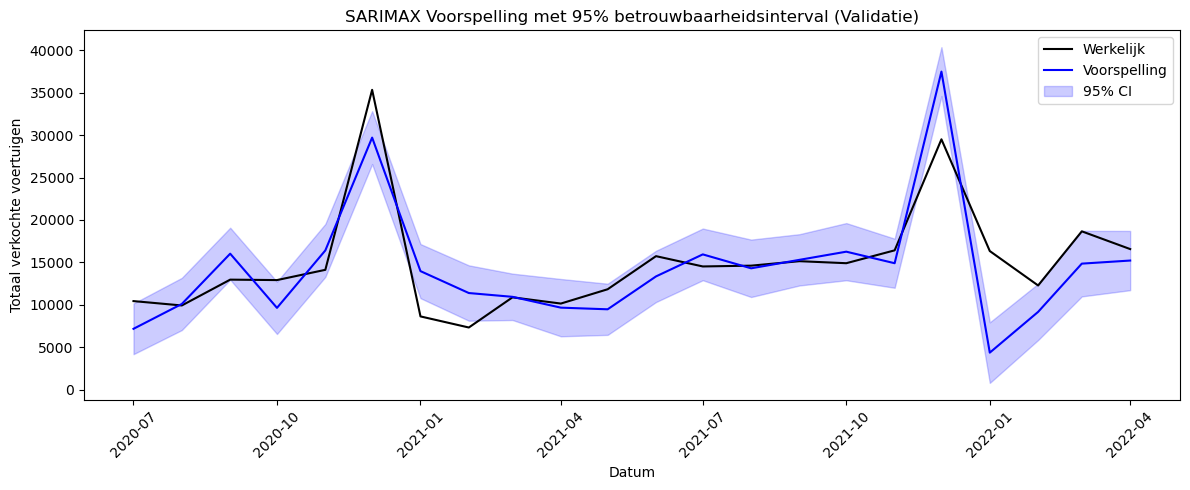

In [30]:
features = [
    'thuis opladen',
    'Bijtelling (%)',
    'Economisch klimaat',
    'Koopbereidheid',
    'hybride elektrisch'
]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# === ARIMAX Wrapper ===
class ARIMAXWrapper:
    def __init__(self, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model_fit = None
        self.scaler = None

    def fit(self, X, y):
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        model = SARIMAX(
            endog=y,
            exog=X_scaled,
            order=self.order,
            seasonal_order=self.seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        self.model_fit = model.fit(disp=False)
        return self

    def predict(self, X, return_conf_int=False):
        if self.model_fit is None or self.scaler is None:
            raise ValueError("Model not fitted yet")
        X_scaled = self.scaler.transform(X)
        forecast = self.model_fit.get_forecast(steps=len(X), exog=X_scaled)
        if return_conf_int:
            conf_int = forecast.conf_int(alpha=0.05)
            return forecast.predicted_mean, conf_int
        else:
            return forecast.predicted_mean


# === Expanding window validation ===
def strict_expanding_window_validation(
    df, features, target_col, model_fn, forecast_horizon=3, return_ci=False
):
    n = len(df)
    val_start = int(n * 0.75)
    test_start = int(n * 0.85)

    X = df[features].values
    y = df[target_col].values

    val_preds, val_actuals, val_dates = [], [], []
    val_ci_lower, val_ci_upper = [], []

    for i in range(val_start, test_start - forecast_horizon + 1):
        X_train = X[:i]
        y_train = y[:i]
        X_val = X[i:i + forecast_horizon]
        y_val = y[i:i + forecast_horizon]

        model = model_fn()
        model.fit(X_train, y_train)

        if return_ci:
            preds, conf = model.predict(X_val, return_conf_int=True)
            val_preds.extend(preds)
            val_ci_lower.extend(conf[:, 0])
            val_ci_upper.extend(conf[:, 1])
        else:
            preds = model.predict(X_val)
            val_preds.extend(preds)

        val_actuals.extend(y_val)
        val_dates.extend(df.iloc[i:i + forecast_horizon]['Periode'].values)

    result = {
        "val_mae": mean_absolute_error(val_actuals, val_preds),
        "val_rmse": np.sqrt(mean_squared_error(val_actuals, val_preds)),
        "val_r2": r2_score(val_actuals, val_preds),
        "val_mape": mean_absolute_percentage_error(val_actuals, val_preds),
        "val_preds": np.array(val_preds),
        "val_actuals": np.array(val_actuals),
        "val_dates": np.array(val_dates)
    }

    if return_ci:
        result["val_ci_lower"] = np.array(val_ci_lower)
        result["val_ci_upper"] = np.array(val_ci_upper)

    return result

# === Run ARIMAX ===
res = strict_expanding_window_validation(
    df,
    features=features,
    target_col='Totaal_verkochte_wegvoertuigen',
    model_fn=lambda: ARIMAXWrapper(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)),
    forecast_horizon=1,
    return_ci=True
)

print("Validation Results:")
print(f"MAPE: {res['val_mape']:.4f}")
print(f"MAE : {res['val_mae']:.2f}")
print(f"RMSE: {res['val_rmse']:.2f}")
print(f"R²  : {res['val_r2']:.3f}")

# === Visualisatie ===
plt.figure(figsize=(12, 5))
plt.plot(res['val_dates'], res['val_actuals'], label='Werkelijk', color='black')
plt.plot(res['val_dates'], res['val_preds'], label='Voorspelling', color='blue')

if 'val_ci_lower' in res and 'val_ci_upper' in res:
    plt.fill_between(
        res['val_dates'],
        res['val_ci_lower'],
        res['val_ci_upper'],
        color='blue', alpha=0.2, label='95% CI'
    )

plt.title('SARIMAX Voorspelling met 95% betrouwbaarheidsinterval (Validatie)')
plt.xlabel('Datum')
plt.ylabel('Totaal verkochte voertuigen')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [34]:
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

model_fn=lambda: ARIMAXWrapper(order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))


# Top 5 features (volgorde uit top5)
top5_features = top5.index.tolist()

# Validation split
n = len(df)
val_start = int(n * 0.75)
test_start = int(n * 0.85)
target_col = 'Totaal_verkochte_wegvoertuigen'

# Helper: SARIMAX wrapper
class ARIMAXWrapper:
    def __init__(self, order=(1, 1, 1)):
        self.order = order
        self.model_fit = None
        self.scaler = None

    def fit(self, X, y):
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        model = SARIMAX(
            endog=y,
            exog=X_scaled,
            order=self.order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        self.model_fit = model.fit(disp=False)
        return self

    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model_fit.forecast(steps=len(X), exog=X_scaled)

# Expanding window validatie (alleen validatie)
def expanding_window_val(df, features, target_col, order=(1,1,1)):
    X = df[features].values if features else np.zeros((len(df), 1))
    y = df[target_col].values
    val_preds, val_actuals = [], []
    for i in range(val_start, test_start):
        X_train = X[:i]
        y_train = y[:i]
        X_val = X[i:i+1]
        y_val = y[i:i+1]
        model = ARIMAXWrapper(order=order)
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        val_preds.append(pred[0])
        val_actuals.append(y_val[0])
    mape = mean_absolute_percentage_error(val_actuals, val_preds)
    mae = mean_absolute_error(val_actuals, val_preds)
    r2 = r2_score(val_actuals, val_preds)
    return mape, mae, r2

selected = []
remaining = top5_features.copy()
results = []
best_mape = None

print("Stepwise feature selection (SARIMAX, expanding window validation):")
for step in range(len(top5_features)):
    best_score = None
    best_feat = None
    for feat in remaining:
        feats = selected + [feat]
        mape, mae, r2 = expanding_window_val(df, feats, target_col)
        if (best_score is None) or (mape < best_score):
            best_score = mape
            best_feat = feat
            best_mae = mae
            best_r2 = r2
    # Stop if no improvement
    if best_mape is not None and best_score >= best_mape - 0.001:
        print(f"Stop: marginal improvement (ΔMAPE={best_mape-best_score:.4f})")
        break
    selected.append(best_feat)
    remaining.remove(best_feat)
    best_mape = best_score
    results.append((selected.copy(), best_mape, best_mae, best_r2))
    print(f"Step {step+1}: features={selected} | MAPE={best_mape:.4f}, MAE={best_mae:.2f}, R²={best_r2:.3f}")

# Resulten overzicht
print("\nFeature selection progression:")
for i, (feats, mape, mae, r2) in enumerate(results, 1):
    print(f"{i}. {feats} | MAPE={mape:.4f}, MAE={mae:.2f}, R²={r2:.3f}")

Stepwise feature selection (SARIMAX, expanding window validation):
Step 1: features=['Bijtelling (%)'] | MAPE=0.3222, MAE=4577.20, R²=-0.376
Step 2: features=['Bijtelling (%)', 'thuis opladen'] | MAPE=0.3160, MAE=4557.10, R²=-0.428
Stop: marginal improvement (ΔMAPE=-0.0112)

Feature selection progression:
1. ['Bijtelling (%)'] | MAPE=0.3222, MAE=4577.20, R²=-0.376
2. ['Bijtelling (%)', 'thuis opladen'] | MAPE=0.3160, MAE=4557.10, R²=-0.428


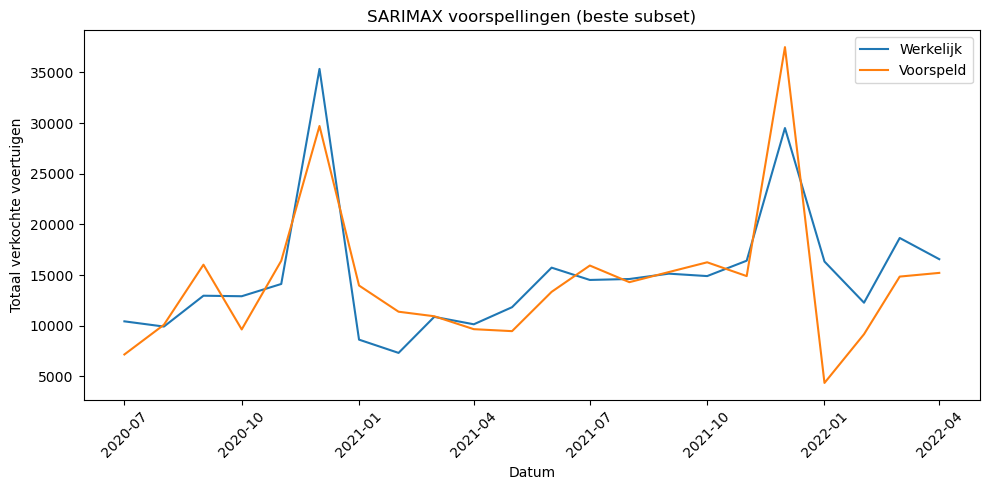

In [35]:
import matplotlib.pyplot as plt

# Gebruik de resultaten uit de laatste SARIMAX validatie (res dict uit cell 23/24)
val_actuals = res['val_actuals']
val_preds = res['val_preds']
val_dates = res['val_dates']

plt.figure(figsize=(10, 5))
plt.plot(val_dates, val_actuals, label="Werkelijk")
plt.plot(val_dates, val_preds, label="Voorspeld")
plt.legend()
plt.title("SARIMAX voorspellingen (beste subset)")
plt.xlabel("Datum")
plt.ylabel("Totaal verkochte voertuigen")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [23]:
features = [
    'thuis opladen',
    'Bijtelling (%)',
    'Economisch klimaat',
    'Koopbereidheid',
    'hybride elektrisch'
]

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# === ARIMAX Wrapper ===
class ARIMAXWrapper:
    def __init__(self, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model_fit = None
        self.scaler = None

    def fit(self, X, y):
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)

        model = SARIMAX(
            endog=y,
            exog=X_scaled,
            order=self.order,
            seasonal_order=self.seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        self.model_fit = model.fit(disp=False)
        return self

    def predict(self, X, return_conf_int=False):
        if self.model_fit is None or self.scaler is None:
            raise ValueError("Model not fitted yet")

        X_scaled = self.scaler.transform(X)
        forecast = self.model_fit.get_forecast(steps=len(X), exog=X_scaled)

        if return_conf_int:
            conf_int = forecast.conf_int(alpha=0.05)
            return forecast.predicted_mean, conf_int
        else:
            return forecast.predicted_mean


# === Expanding window validation (Validation only) ===
def strict_expanding_window_validation(
    df, features, target_col, model_fn, forecast_horizon=3, return_ci=False
):
    n = len(df)
    val_start = int(n * 0.75)
    test_start = int(n * 0.85)

    X = df[features].values
    y = df[target_col].values

    val_preds, val_actuals, val_dates = [], [], []
    val_ci_lower, val_ci_upper = [], []

    for i in range(val_start, test_start - forecast_horizon + 1):
        X_train = X[:i]
        y_train = y[:i]
        X_val = X[i:i + forecast_horizon]
        y_val = y[i:i + forecast_horizon]

        model = model_fn()
        model.fit(X_train, y_train)

        if return_ci:
            preds, conf = model.predict(X_val, return_conf_int=True)
            val_ci_lower.extend(conf[:, 0])
            val_ci_upper.extend(conf[:, 1])
        else:
            preds = model.predict(X_val)

        val_preds.extend(preds)
        val_actuals.extend(y_val)
        val_dates.extend(df.iloc[i:i + forecast_horizon]['Periode'].values)

    result = {
        "val_mae": mean_absolute_error(val_actuals, val_preds),
        "val_rmse": np.sqrt(mean_squared_error(val_actuals, val_preds)),
        "val_r2": r2_score(val_actuals, val_preds),
        "val_mape": mean_absolute_percentage_error(val_actuals, val_preds),
        "val_preds": np.array(val_preds),
        "val_actuals": np.array(val_actuals),
        "val_dates": np.array(val_dates)
    }

    if return_ci:
        result["val_ci_lower"] = np.array(val_ci_lower)
        result["val_ci_upper"] = np.array(val_ci_upper)

    return result

top_features = [  'thuis opladen',
    'Bijtelling (%)',
    'Economisch klimaat',
    'Koopbereidheid',
    'hybride elektrisch']

res = strict_expanding_window_validation(
    df,
    features=top_features,
    target_col='Totaal_verkochte_wegvoertuigen',
    model_fn=lambda: ARIMAXWrapper(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)),
    forecast_horizon=3,
    return_ci=True
)

print("Validation Results:")
print(f"MAPE: {res['val_mape']:.4f}")
print(f"MAE : {res['val_mae']:.2f}")
print(f"RMSE: {res['val_rmse']:.2f}")
print(f"R²  : {res['val_r2']:.3f}")


Validation Results:
MAPE: 0.2492
MAE : 3418.30
RMSE: 4633.83
R²  : 0.482


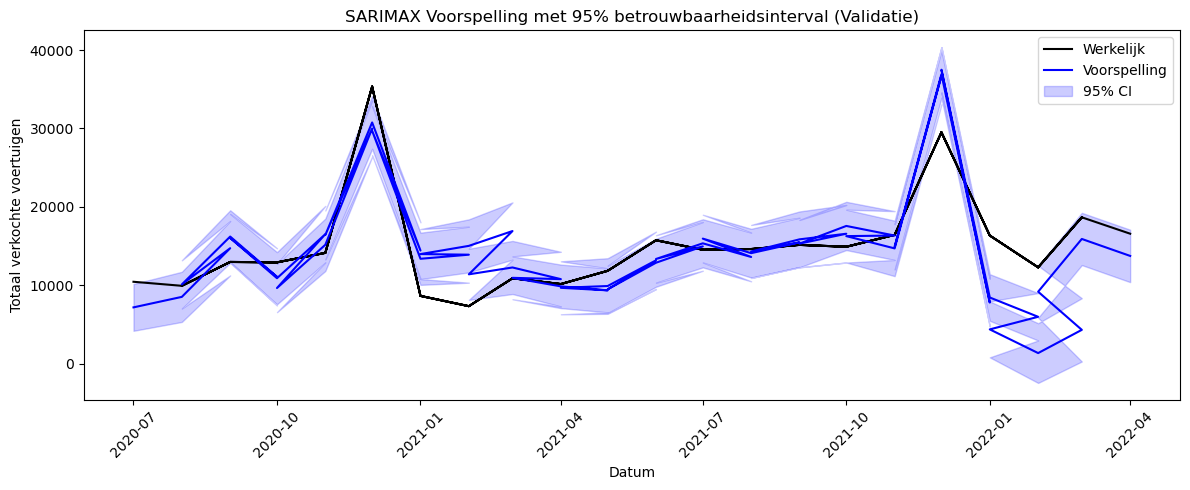

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(res['val_dates'], res['val_actuals'], label='Werkelijk', color='black')
plt.plot(res['val_dates'], res['val_preds'], label='Voorspelling', color='blue')

# Zorg dat alle arrays dezelfde lengte hebben voor fill_between
if 'val_ci_lower' in res and 'val_ci_upper' in res:
    min_len = min(len(res['val_dates']), len(res['val_ci_lower']), len(res['val_ci_upper']))
    plt.fill_between(
        res['val_dates'][:min_len],
        res['val_ci_lower'][:min_len],
        res['val_ci_upper'][:min_len],
        color='blue', alpha=0.2, label='95% CI'
    )

plt.title('SARIMAX Voorspelling met 95% betrouwbaarheidsinterval (Validatie)')
plt.xlabel('Datum')
plt.ylabel('Totaal verkochte voertuigen')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:
# Print train/val/test split dates and percentages
n = len(df)
train_end = int(n * 0.75)
val_end = int(n * 0.85)
test_end = n

print("Train:")
print(f"  Start: {df['Periode'].iloc[0].strftime('%Y-%m')}")
print(f"  End:   {df['Periode'].iloc[train_end-1].strftime('%Y-%m')}")
print(f"  Size:  {train_end} ({train_end/n:.1%})")

print("\nValidation:")
print(f"  Start: {df['Periode'].iloc[train_end].strftime('%Y-%m')}")
print(f"  End:   {df['Periode'].iloc[val_end-1].strftime('%Y-%m')}")
print(f"  Size:  {val_end-train_end} ({(val_end-train_end)/n:.1%})")

print("\nTest:")
print(f"  Start: {df['Periode'].iloc[val_end].strftime('%Y-%m')}")
print(f"  End:   {df['Periode'].iloc[test_end-1].strftime('%Y-%m')}")
print(f"  Size:  {test_end-val_end} ({(test_end-val_end)/n:.1%})")

Train:
  Start: 2007-01
  End:   2020-06
  Size:  162 (74.7%)

Validation:
  Start: 2020-07
  End:   2022-04
  Size:  22 (10.1%)

Test:
  Start: 2022-05
  End:   2025-01
  Size:  33 (15.2%)


In [5]:
# Load data
df = pd.read_csv(r"e:/Nieuw dataset/Joined trends/joined_trend_sales_All1.csv")
df["Periode"] = pd.to_datetime(df["Periode"], format="%Y/%m")
df = df.sort_values("Periode").reset_index(drop=True)

# Create lag features and date parts
for lag in range(1, 7):
    df[f"TVV_Lag{lag}"] = df["Totaal_verkochte_wegvoertuigen"].shift(lag)
df_lagged = df.dropna().reset_index(drop=True)
df_lagged['year'] = df_lagged['Periode'].dt.year
df_lagged['month'] = df_lagged['Periode'].dt.month
df_lagged['quarter'] = df_lagged['Periode'].dt.quarter
cols = [col for col in df_lagged.columns if col != 'Totaal_verkochte_wegvoertuigen'] + ['Totaal_verkochte_wegvoertuigen']
df_lagged = df_lagged[cols]

In [6]:
# Define lag and time features to add to all subsets
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

# Redefine feature sets with those always included
feature_sets = {
    'Lag Only': lag_time_features,
    'Keywords + Lag': lag_time_features + ['thuis opladen', 'elektrische auto', 'hybride elektrisch'],
    'Bijtelling + Lag': lag_time_features + ['Bijtelling (%)'],
    'Confidence + Lag': lag_time_features + ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen'],
    'Fuel + Lag': lag_time_features + [
        'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
        'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
        'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
    ]
}

# Add full feature set: everything except target and 'Periode'
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lag_time_features

feature_sets['All Features'] = all_features

 Aangepaste versie mét rolling test forecast

In [7]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def strict_expanding_window_validation(
    df, features, target_col, model_fn,
    forecast_horizon=3
):
    n = len(df)
    test_start = int(n * 0.85)
    val_start = int(n * 0.75)

    X = df[features].values
    y = df[target_col].values

    # === VALIDATIE (expanding window binnen trainval) ===
    val_preds, val_actuals, val_dates = [], [], []
    for i in range(val_start, test_start - forecast_horizon + 1):
        X_train = X[:i]
        y_train = y[:i]
        X_val = X[i:i+forecast_horizon]
        y_val = y[i:i+forecast_horizon]

        model = model_fn()
        model.fit(X_train, y_train)
        preds = model.predict(X_val)

        val_preds.extend(preds)
        val_actuals.extend(y_val)
        val_dates.extend(df.iloc[i:i+forecast_horizon]['Periode'].values)

    # === TEST (rolling window vanaf test_start) ===
    test_preds, test_actuals, test_dates = [], [], []
    for i in range(test_start, n - forecast_horizon + 1):
        X_train = X[:i]
        y_train = y[:i]
        X_test = X[i:i+forecast_horizon]
        y_test = y[i:i+forecast_horizon]

        model = model_fn()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        test_preds.extend(preds)
        test_actuals.extend(y_test)
        test_dates.extend(df.iloc[i:i+forecast_horizon]['Periode'].values)

    # === Scores ===
    val_mae = mean_absolute_error(val_actuals, val_preds)
    val_rmse = np.sqrt(mean_squared_error(val_actuals, val_preds))
    val_r2 = r2_score(val_actuals, val_preds)
    val_mape = mean_absolute_percentage_error(val_actuals, val_preds)

    test_mae = mean_absolute_error(test_actuals, test_preds)
    test_rmse = np.sqrt(mean_squared_error(test_actuals, test_preds))
    test_r2 = r2_score(test_actuals, test_preds)
    test_mape = mean_absolute_percentage_error(test_actuals, test_preds)

    return {
        "val_mae": val_mae,
        "val_rmse": val_rmse,
        "val_r2": val_r2,
        "val_mape": val_mape,
        "val_preds": np.array(val_preds),
        "val_actuals": np.array(val_actuals),
        "val_dates": np.array(val_dates),
        "test_mae": test_mae,
        "test_rmse": test_rmse,
        "test_r2": test_r2,
        "test_mape": test_mape,
        "test_preds": np.array(test_preds),
        "test_actuals": np.array(test_actuals),
        "test_dates": np.array(test_dates)
    }


### Explanation of the Data Split and Expanding Window Validation

This function implements a strict time series split with expanding window validation and a rolling test forecast. The data is divided as follows:

- **Training set:** The first 75% of the data (from the start up to 75% of the timeline).
- **Validation set:** The next 10% of the data (from 75% to 85% of the timeline). Validation is performed using an expanding window: for each step, the model is trained on all data up to that point and validated on the next `forecast_horizon` periods.
- **Test set:** The final 15% of the data (from 85% to 100% of the timeline). Testing is also done with a rolling window: for each step, the model is trained on all data up to that point and tested on the next `forecast_horizon` periods.

**Key points:**
- At every step, only past data is used to predict future values, preventing lookahead bias and data leakage.
- The validation and test predictions are made in a way that simulates real-world forecasting, where only information up to the prediction date is available.
- This approach is robust for time series forecasting and ensures that model evaluation is realistic and fair.


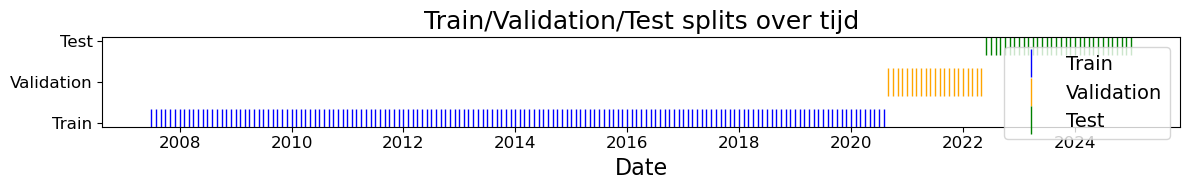

Train months: 2007-07 -> 2020-08 (158 maanden)
Validation months: 2020-09 -> 2022-05 (21 maanden)
Test months: 2022-06 -> 2025-01 (32 maanden)


In [27]:
import matplotlib.pyplot as plt

# Bepaal de indexen voor splits (zelfde logica als in je validatiefunctie)
n = len(df_lagged)
train_end = int(n * 0.75)
val_end = int(n * 0.85)
test_end = n

train_dates = df_lagged['Periode'].iloc[:train_end]
val_dates = df_lagged['Periode'].iloc[train_end:val_end]
test_dates = df_lagged['Periode'].iloc[val_end:test_end]

plt.figure(figsize=(12, 2))
plt.plot(train_dates, [1]*len(train_dates), '|', color='blue', markersize=20, label='Train')
plt.plot(val_dates, [2]*len(val_dates), '|', color='orange', markersize=20, label='Validation')
plt.plot(test_dates, [3]*len(test_dates), '|', color='green', markersize=20, label='Test')

plt.yticks([1, 2, 3], ['Train', 'Validation', 'Test'])
plt.xlabel('Date')
plt.title('Train/Validation/Test splits over tijd')
plt.legend()
plt.tight_layout()
plt.show()
print("Train months:", train_dates.min().strftime("%Y-%m"), "->", train_dates.max().strftime("%Y-%m"), f"({len(train_dates)} maanden)")
print("Validation months:", val_dates.min().strftime("%Y-%m"), "->", val_dates.max().strftime("%Y-%m"), f"({len(val_dates)} maanden)")
print("Test months:", test_dates.min().strftime("%Y-%m"), "->", test_dates.max().strftime("%Y-%m"), f"({len(test_dates)} maanden)")


In [20]:
print("Train dates:")
print(df_lagged['Periode'].iloc[:train_end].min(), "->", df_lagged['Periode'].iloc[:train_end].max())
print("Aantal train:", train_end, f"({train_end/len(df_lagged)*100:.1f}%)")

print("\nValidation dates:")
print(df_lagged['Periode'].iloc[train_end:val_end].min(), "->", df_lagged['Periode'].iloc[train_end:val_end].max())
print("Aantal validatie:", val_end - train_end, f"({(val_end-train_end)/len(df_lagged)*100:.1f}%)")

print("\nTest dates:")
print(df_lagged['Periode'].iloc[val_end:test_end].min(), "->", df_lagged['Periode'].iloc[val_end:test_end].max())
print("Aantal test:", test_end - val_end, f"({(test_end-val_end)/len(df_lagged)*100:.1f}%)")

Train dates:
2007-07-01 00:00:00 -> 2020-08-01 00:00:00
Aantal train: 158 (74.9%)

Validation dates:
2020-09-01 00:00:00 -> 2022-05-01 00:00:00
Aantal validatie: 21 (10.0%)

Test dates:
2022-06-01 00:00:00 -> 2025-01-01 00:00:00
Aantal test: 32 (15.2%)


#### Nulmodel

Mask sum: 21 (should be >0)
Random Walk (Lag Only) nulmodel MAPE: 0.3480


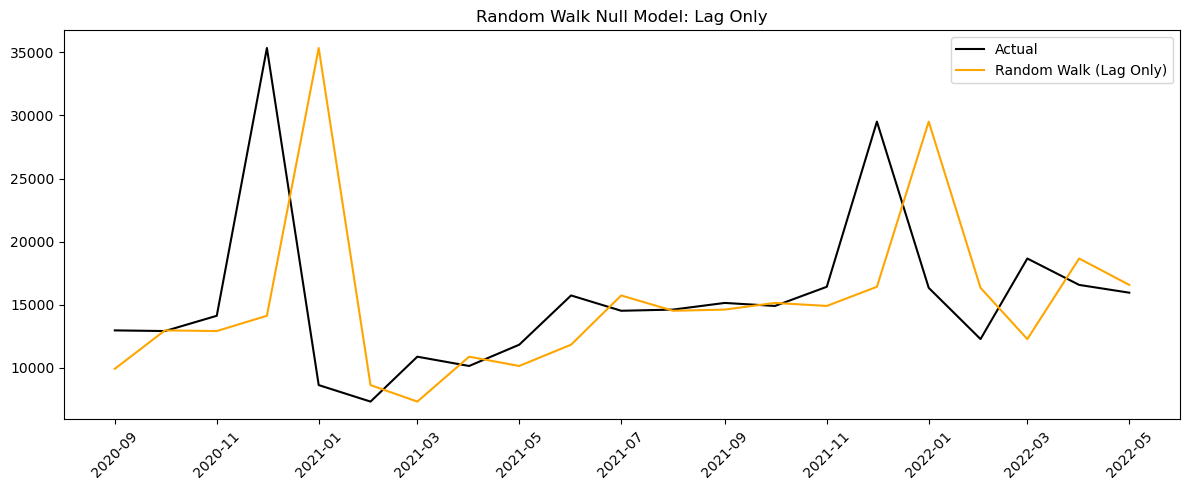

In [22]:

from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Haal de validatiedatums op uit je model-validatie (gebruik dezelfde split!)
val_dates = strict_expanding_window_validation(
    df_lagged, feature_sets['Lag Only'], 'Totaal_verkochte_wegvoertuigen',
    lambda: xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, 
                             learning_rate=0.1, max_depth=3, random_state=42, eval_metric="rmse"),
    forecast_horizon=3
)['val_dates']
val_dates = pd.to_datetime(val_dates)

results = {}
for label, features in feature_sets.items():
    if label != 'Lag Only':
        continue

    val_preds = df_lagged['TVV_Lag1'].values
    val_actuals = df_lagged['Totaal_verkochte_wegvoertuigen'].values
    validation_dates = pd.to_datetime(df_lagged['Periode'].values)

    # Filter alleen de datums die in de validatieset zitten
    mask = validation_dates.isin(val_dates)
    print(f"Mask sum: {mask.sum()} (should be >0)")
    val_preds = val_preds[mask]
    val_actuals = val_actuals[mask]
    validation_dates = validation_dates[mask]

    results[label] = pd.DataFrame({
        'date': validation_dates,
        'actual': val_actuals,
        'pred': val_preds
    }).drop_duplicates(subset='date', keep='first')

    # MAPE voor Random Walk (Lag Only) nulmodel op validatieset
    mape_lag = mean_absolute_percentage_error(val_actuals, val_preds)
    print(f"Random Walk (Lag Only) nulmodel MAPE: {mape_lag:.4f}")

df_lag = results['Lag Only'][['date', 'actual', 'pred']].rename(columns={'pred': 'pred_lag'})

plt.figure(figsize=(12, 5))
plt.plot(df_lag['date'], df_lag['actual'], label='Actual', color='black')
plt.plot(df_lag['date'], df_lag['pred_lag'], label='Random Walk (Lag Only)', color='orange')
plt.title('Random Walk Null Model: Lag Only')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Baseline

#### XGBoost

XGBoost (Lag Only): MAPE=0.2111, MAE=3138.81, RMSE=4217.81, R²=0.578
XGBoost (All Features): MAPE=0.3174, MAE=4282.95, RMSE=6666.06, R²=-0.054


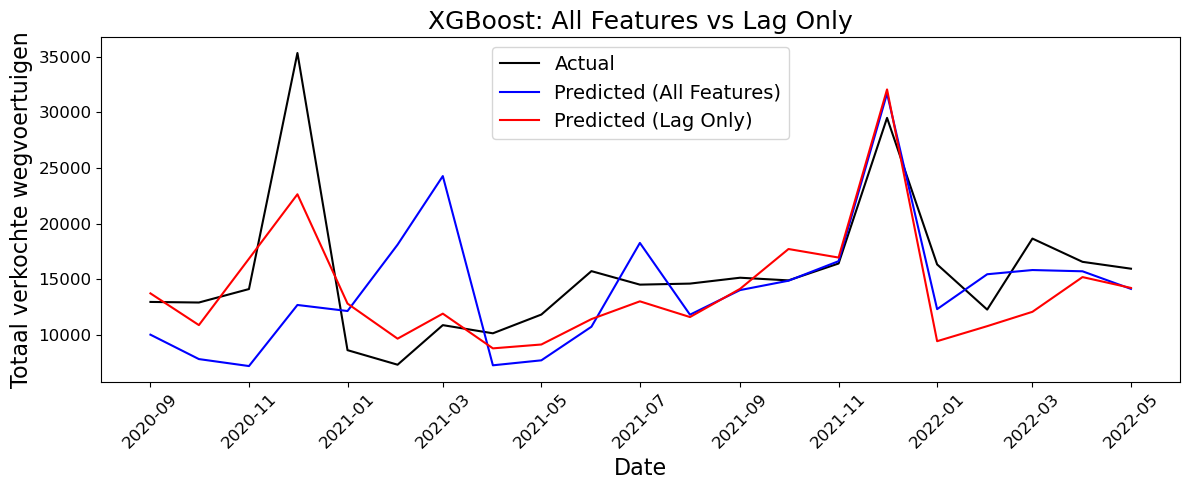

In [23]:


results = {}
for label, features in feature_sets.items():
    if label not in ['Lag Only', 'All Features']:
        continue  # Sla andere feature sets over

    res = strict_expanding_window_validation(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100,
                                 learning_rate=0.1, max_depth=3, random_state=42, eval_metric="rmse"),
        forecast_horizon=3
    )
    print(f"XGBoost ({label}): MAPE={res['val_mape']:.4f}, MAE={res['val_mae']:.2f}, RMSE={res['val_rmse']:.2f}, R²={res['val_r2']:.3f}")

    # Sla resultaten op in dictionary
    results[label] = {
        'date': pd.to_datetime(res['val_dates']),
        'actual': res['val_actuals'],
        'pred': res['val_preds']
    }

# Maak DataFrames van de resultaten
df_all = pd.DataFrame(results['All Features']).drop_duplicates(subset='date', keep='first')
df_lag = pd.DataFrame(results['Lag Only']).drop_duplicates(subset='date', keep='first')

# Merge op datum
df_merged = pd.merge(
    df_all[['date', 'actual', 'pred']].rename(columns={'pred': 'pred_all'}),
    df_lag[['date', 'pred']].rename(columns={'pred': 'pred_lag'}),
    on='date',
    how='inner'
)

plt.rcParams.update({'legend.fontsize': 14, 'axes.labelsize': 16, 'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
plt.figure(figsize=(12, 5))
plt.plot(df_merged['date'], df_merged['actual'], label='Actual', color='black')
plt.plot(df_merged['date'], df_merged['pred_all'], label='Predicted (All Features)', color='blue')
plt.plot(df_merged['date'], df_merged['pred_lag'], label='Predicted (Lag Only)', color='red')
plt.title('XGBoost: All Features vs Lag Only')
plt.xlabel('Date')
plt.ylabel('Totaal verkochte wegvoertuigen')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




#### Arimax

ARIMAX (Lag Only): MAPE=0.5708, MAE=7854.58, RMSE=11046.13, R²=-1.895
ARIMAX (All Features): MAPE=0.5690, MAE=7596.93, RMSE=12042.74, R²=-2.441


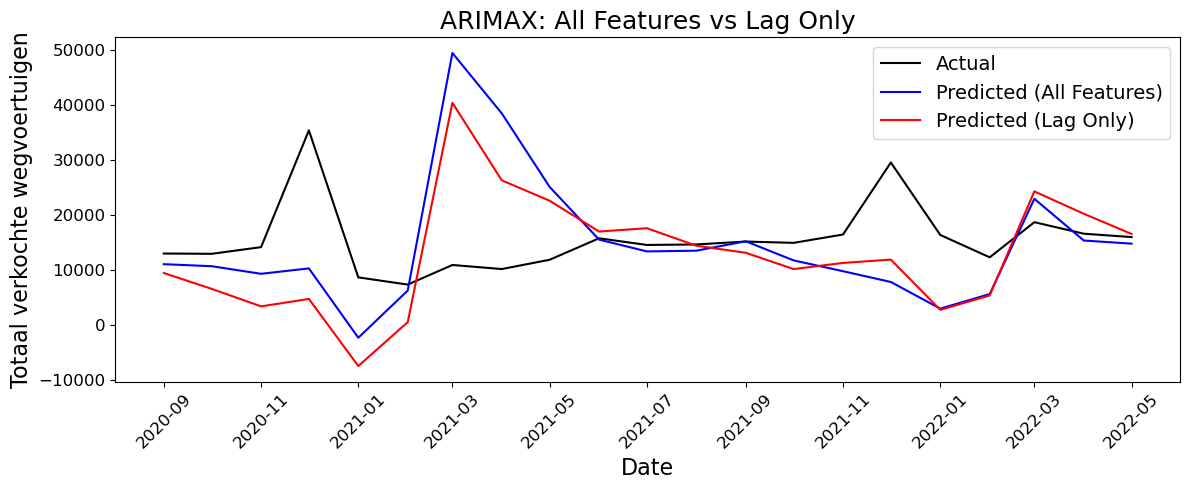

In [26]:
from sklearn.preprocessing import StandardScaler

# ARIMAX wrapper met standaardisatie
class ARIMAXWrapper:
    def __init__(self, order=(1, 1, 1)):
        self.order = order
        self.model_fit = None
        self.scaler = None
        
    def fit(self, X, y):
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        model = SARIMAX(y, exog=X_scaled, order=self.order,
                        enforce_stationarity=False, enforce_invertibility=False)
        self.model_fit = model.fit(disp=False)
        return self
        
    def predict(self, X):
        if self.model_fit is None or self.scaler is None:
            raise ValueError("Model not fitted yet")
        X_scaled = self.scaler.transform(X)
        return self.model_fit.forecast(steps=len(X), exog=X_scaled)

arimax_results = {}

# Voer ARIMAX uit voor beide feature sets
for label, features in feature_sets.items():
    if label not in ['Lag Only', 'All Features']:
        continue

    res = strict_expanding_window_validation(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen',
        lambda: ARIMAXWrapper(order=(1, 1, 1)),
        forecast_horizon=3
    )

    print(f"ARIMAX ({label}): MAPE={res['val_mape']:.4f}, MAE={res['val_mae']:.2f}, RMSE={res['val_rmse']:.2f}, R²={res['val_r2']:.3f}")

    # Sla resultaten op
    arimax_results[label] = {
        'date': pd.to_datetime(res['val_dates']),
        'actual': res['val_actuals'],
        'pred': res['val_preds']
    }

# Maak DataFrames en merge net als bij XGBoost
df_arimax_all = pd.DataFrame(arimax_results['All Features']).drop_duplicates(subset='date', keep='first')
df_arimax_lag = pd.DataFrame(arimax_results['Lag Only']).drop_duplicates(subset='date', keep='first')

df_arimax_merged = pd.merge(
    df_arimax_all[['date', 'actual', 'pred']].rename(columns={'pred': 'pred_all'}),
    df_arimax_lag[['date', 'pred']].rename(columns={'pred': 'pred_lag'}),
    on='date',
    how='inner'
)

# Plot vergelijkende ARIMAX-grafiek
plt.rcParams.update({'legend.fontsize': 14, 'axes.labelsize': 16, 'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
plt.figure(figsize=(12, 5))
plt.plot(df_arimax_merged['date'], df_arimax_merged['actual'], label='Actual', color='black')
plt.plot(df_arimax_merged['date'], df_arimax_merged['pred_all'], label='Predicted (All Features)', color='blue')
plt.plot(df_arimax_merged['date'], df_arimax_merged['pred_lag'], label='Predicted (Lag Only)', color='red')
plt.title('ARIMAX: All Features vs Lag Only')
plt.xlabel('Date')
plt.ylabel('Totaal verkochte wegvoertuigen')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Sarimax extra edit 

In [ ]:
# Define your top_features list, e.g.:
top_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
]

def test_single_feature_model(features):
    res = strict_expanding_window_validation(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100,
                                 learning_rate=0.1, max_depth=3, random_state=42, eval_metric="rmse"),
        forecast_horizon=3
    )
    print(f"Feature(s): {features} | MAPE={res['val_mape']:.4f}, MAE={res['val_mae']:.2f}, RMSE={res['val_rmse']:.2f}, R²={res['val_r2']:.3f}")

for f in top_features:
    test_single_feature_model([f])


In [6]:
# Define your top_features list, e.g.:
top_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
]

def test_single_feature_model(features):
    res = strict_expanding_window_validation(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100,
                                 learning_rate=0.1, max_depth=3, random_state=42, eval_metric="rmse"),
        forecast_horizon=3
    )
    print(f"Feature(s): {features} | MAPE={res['val_mape']:.4f}, MAE={res['val_mae']:.2f}, RMSE={res['val_rmse']:.2f}, R²={res['val_r2']:.3f}")

for f in top_features:
    test_single_feature_model([f])


Feature(s): ['thuis opladen'] | MAPE=0.4714, MAE=8243.85, RMSE=10999.33, R²=-1.871
Feature(s): ['elektrische auto'] | MAPE=0.3356, MAE=5268.34, RMSE=7688.45, R²=-0.403
Feature(s): ['hybride elektrisch'] | MAPE=0.2340, MAE=4461.25, RMSE=7637.72, R²=-0.384
Feature(s): ['Bijtelling (%)'] | MAPE=0.3806, MAE=6668.47, RMSE=9421.36, R²=-1.106
Feature(s): ['Consumentenvertrouwen'] | MAPE=0.8375, MAE=13376.84, RMSE=15068.49, R²=-4.388
Feature(s): ['Economisch klimaat'] | MAPE=0.7933, MAE=12397.02, RMSE=13838.24, R²=-3.544
Feature(s): ['Koopbereidheid'] | MAPE=0.8012, MAE=12821.97, RMSE=14696.41, R²=-4.125
Feature(s): ['Grote aankopen'] | MAPE=0.8416, MAE=13234.04, RMSE=14857.72, R²=-4.238
Feature(s): ['BenzineEuro95_1_first'] | MAPE=0.6826, MAE=10391.43, RMSE=12522.52, R²=-2.721
Feature(s): ['BenzineEuro95_1_last'] | MAPE=0.5384, MAE=8101.20, RMSE=10887.96, R²=-1.813
Feature(s): ['BenzineEuro95_1_min'] | MAPE=0.5798, MAE=8804.15, RMSE=11212.39, R²=-1.983
Feature(s): ['BenzineEuro95_1_max'] | MA

In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# === ARIMAX Wrapper ===
class ARIMAXWrapper:
    def __init__(self, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model_fit = None
        self.scaler = None

    def fit(self, X, y):
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)

        model = SARIMAX(
            endog=y,
            exog=X_scaled,
            order=self.order,
            seasonal_order=self.seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        self.model_fit = model.fit(disp=False)
        return self

    def predict(self, X, return_conf_int=False):
        if self.model_fit is None or self.scaler is None:
            raise ValueError("Model not fitted yet")

        X_scaled = self.scaler.transform(X)
        forecast = self.model_fit.get_forecast(steps=len(X), exog=X_scaled)

        if return_conf_int:
            conf_int = forecast.conf_int(alpha=0.05)
            return forecast.predicted_mean, conf_int
        else:
            return forecast.predicted_mean


# === Expanding window validation (Validation only) ===
def strict_expanding_window_validation(
    df, features, target_col, model_fn, forecast_horizon=3, return_ci=False
):
    n = len(df)
    val_start = int(n * 0.75)
    test_start = int(n * 0.85)

    X = df[features].values
    y = df[target_col].values

    val_preds, val_actuals, val_dates = [], [], []
    val_ci_lower, val_ci_upper = [], []

    for i in range(val_start, test_start - forecast_horizon + 1):
        X_train = X[:i]
        y_train = y[:i]
        X_val = X[i:i + forecast_horizon]
        y_val = y[i:i + forecast_horizon]

        model = model_fn()
        model.fit(X_train, y_train)

        if return_ci:
            preds, conf = model.predict(X_val, return_conf_int=True)
            val_ci_lower.extend(conf[:, 0])
            val_ci_upper.extend(conf[:, 1])
        else:
            preds = model.predict(X_val)

        val_preds.append(preds[0])
        val_actuals.append(y_val[0])
        val_dates.append(df.iloc[i]['Periode'])
        if return_ci:
            val_ci_lower.append(conf[0, 0])
            val_ci_upper.append(conf[0, 1])

    result = {
        "val_mae": mean_absolute_error(val_actuals, val_preds),
        "val_rmse": np.sqrt(mean_squared_error(val_actuals, val_preds)),
        "val_r2": r2_score(val_actuals, val_preds),
        "val_mape": mean_absolute_percentage_error(val_actuals, val_preds),
        "val_preds": np.array(val_preds),
        "val_actuals": np.array(val_actuals),
        "val_dates": np.array(val_dates)
    }

    if return_ci:
        result["val_ci_lower"] = np.array(val_ci_lower)
        result["val_ci_upper"] = np.array(val_ci_upper)

    return result

top_features = ['hybride elektrisch', 'elektrische auto', 'Bijtelling (%)']

res = strict_expanding_window_validation(
    df_lagged,
    features=top_features,
    target_col='Totaal_verkochte_wegvoertuigen',
    model_fn=lambda: ARIMAXWrapper(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)),
    forecast_horizon=3,
    return_ci=True
)

print("Validation Results:")
print(f"MAPE: {res['val_mape']:.4f}")
print(f"MAE : {res['val_mae']:.2f}")
print(f"RMSE: {res['val_rmse']:.2f}")
print(f"R²  : {res['val_r2']:.3f}")


Validation Results:
MAPE: 0.1894
MAE : 3016.58
RMSE: 3980.00
R²  : 0.627


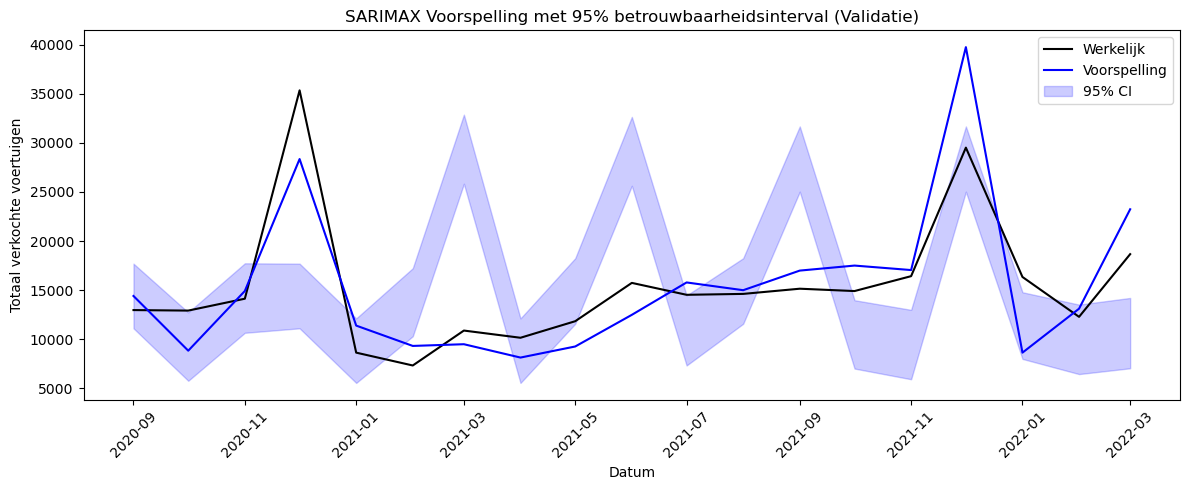

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(res['val_dates'], res['val_actuals'], label='Werkelijk', color='black')
plt.plot(res['val_dates'], res['val_preds'], label='Voorspelling', color='blue')

# Zorg dat alle arrays dezelfde lengte hebben voor fill_between
if 'val_ci_lower' in res and 'val_ci_upper' in res:
    min_len = min(len(res['val_dates']), len(res['val_ci_lower']), len(res['val_ci_upper']))
    plt.fill_between(
        res['val_dates'][:min_len],
        res['val_ci_lower'][:min_len],
        res['val_ci_upper'][:min_len],
        color='blue', alpha=0.2, label='95% CI'
    )

plt.title('SARIMAX Voorspelling met 95% betrouwbaarheidsinterval (Validatie)')
plt.xlabel('Datum')
plt.ylabel('Totaal verkochte voertuigen')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


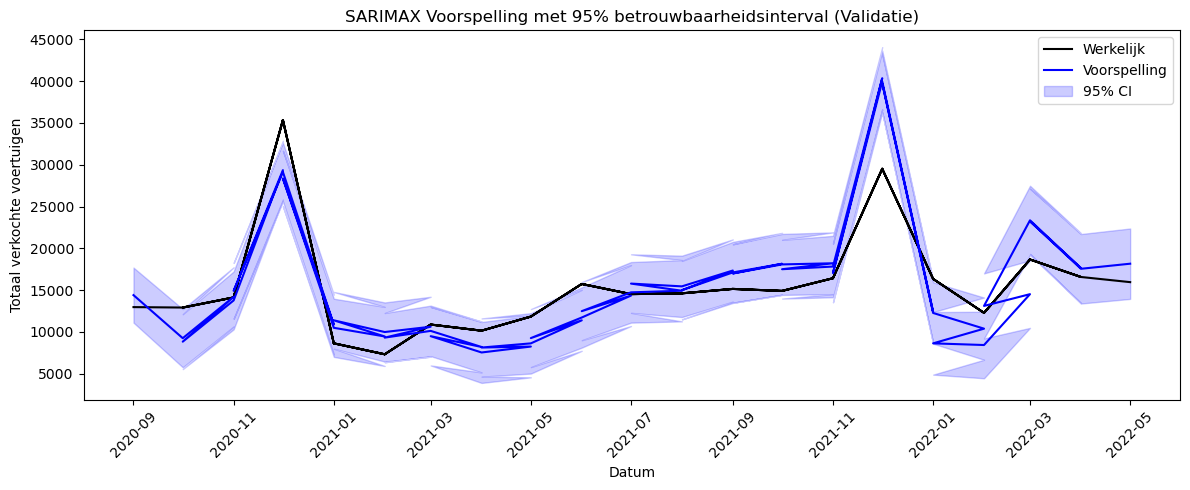

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(res['val_dates'], res['val_actuals'], label='Werkelijk', color='black')
plt.plot(res['val_dates'], res['val_preds'], label='Voorspelling', color='blue')

if 'val_ci_lower' in res and 'val_ci_upper' in res:
    plt.fill_between(res['val_dates'], res['val_ci_lower'], res['val_ci_upper'],
                     color='blue', alpha=0.2, label='95% CI')

plt.title('SARIMAX Voorspelling met 95% betrouwbaarheidsinterval (Validatie)')
plt.xlabel('Datum')
plt.ylabel('Totaal verkochte voertuigen')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Fine tune XGBoost

> Iteratie 1: max_depth

In [ ]:

for max_depth in [1, 2, 3, 5, 7, 9]:
    print(f"\nTesting max_depth={max_depth}")
    res = strict_expanding_window_validation(
        df_lagged, feature_sets['All Features'], 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=max_depth,
            subsample=1.0,
            min_child_weight=1,
            colsample_bytree=1.0,
            random_state=42,
            eval_metric="rmse"
        ),
        forecast_horizon=3
    )
    print(f"max_depth={max_depth}: MAPE={res['val_mape']:.4f}, MAE={res['val_mae']:.2f}, RMSE={res['val_rmse']:.2f}, R²={res['val_r2']:.3f}")


Testing max_depth=1
max_depth=1: MAPE=0.3456, MAE=5258.12, RMSE=7763.27, R²=-0.430

Testing max_depth=2
max_depth=2: MAPE=0.2380, MAE=3760.07, RMSE=6006.65, R²=0.144

Testing max_depth=3
max_depth=3: MAPE=0.3174, MAE=4282.95, RMSE=6666.06, R²=-0.054

Testing max_depth=5
max_depth=5: MAPE=0.3479, MAE=4816.43, RMSE=6888.63, R²=-0.126

Testing max_depth=7
max_depth=7: MAPE=0.3554, MAE=4934.12, RMSE=6944.89, R²=-0.144

Testing max_depth=9
max_depth=9: MAPE=0.3556, MAE=4940.65, RMSE=6955.93, R²=-0.148


max debt van 3 naar 2

> Iteratie 2: min_child_weight

In [38]:

# Baseline MAPE
baseline_mape = 0.2380 

print(f"Baseline MAPE: {baseline_mape:.4f}")

for min_child_weight in [1, 3, 5, 7, 10]:
    print(f"\nTesting min_child_weight={min_child_weight}")
    res = strict_expanding_window_validation(
        df_lagged, feature_sets['All Features'], 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=2,
            min_child_weight=min_child_weight,
            subsample=1.0,
            colsample_bytree=1.0,
            random_state=42,
            eval_metric="rmse"
        ),
        
        forecast_horizon=3
    )
    print(f"min_child_weightAPE={res['val_mape']:.4f}, MAE={res['val_mae']:.2f}, RMSE={res['val_rmse']:.2f}, R²={res['val_r2']:.3f}")

Baseline MAPE: 0.2380

Testing min_child_weight=1
min_child_weightAPE=0.2380, MAE=3760.07, RMSE=6006.65, R²=0.144

Testing min_child_weight=3
min_child_weightAPE=0.3184, MAE=4975.05, RMSE=6760.89, R²=-0.085

Testing min_child_weight=5
min_child_weightAPE=0.2971, MAE=4755.58, RMSE=6821.62, R²=-0.104

Testing min_child_weight=7
min_child_weightAPE=0.2839, MAE=4521.58, RMSE=6634.03, R²=-0.044

Testing min_child_weight=10
min_child_weightAPE=0.2403, MAE=3906.89, RMSE=6273.87, R²=0.066


baseline van 1 werkt het beste/ toont zelfde resultaat 

> iteratie 3: subsample

In [39]:
# Baseline MAPE
baseline_mape = 2380

print(f"Baseline MAPE: {baseline_mape:.4f}")

for subsample in [1.0, 0.8, 0.6, 0.5]:
    print(f"\nTesting subsample={subsample}")
    res = strict_expanding_window_validation(
        df_lagged, feature_sets['All Features'], 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=2,
            min_child_weight=1,
            subsample=subsample,
            colsample_bytree=1.0,
            random_state=42,
            eval_metric="rmse"
        ),
        
        forecast_horizon=3
    )
    print(f"subsample={res['val_mape']:.4f}, MAE={res['val_mae']:.2f}, RMSE={res['val_rmse']:.2f}, R²={res['val_r2']:.3f}")


Baseline MAPE: 2380.0000

Testing subsample=1.0
subsample=0.2380, MAE=3760.07, RMSE=6006.65, R²=0.144

Testing subsample=0.8
subsample=0.2689, MAE=3967.46, RMSE=6296.40, R²=0.059

Testing subsample=0.6
subsample=0.3223, MAE=4692.81, RMSE=6681.07, R²=-0.059

Testing subsample=0.5
subsample=0.3563, MAE=5250.28, RMSE=7173.75, R²=-0.221


subsample default 1 werkt het best 

> iteratie 4': colsample_bytree

In [40]:
baseline_mape = 0.2380
print(f"Baseline MAPE: {baseline_mape:.4f}")
for colsample_bytree in [1.0, 0.8, 0.6, 0.5]:
    print(f"\nTesting colsample_bytree={colsample_bytree}")
    res = strict_expanding_window_validation(
        df_lagged, feature_sets['All Features'], 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=2,
            min_child_weight=1,
            subsample=1,
            colsample_bytree=colsample_bytree,
            random_state=42,
            eval_metric="rmse"
        ),
        forecast_horizon=3
        
    )
    print(f"colsample_bytree={res['val_mape']:.4f}, MAE={res['val_mae']:.2f}, RMSE={res['val_rmse']:.2f}, R²={res['val_r2']:.3f}")


Baseline MAPE: 0.2380

Testing colsample_bytree=1.0
colsample_bytree=0.2380, MAE=3760.07, RMSE=6006.65, R²=0.144

Testing colsample_bytree=0.8
colsample_bytree=0.2642, MAE=4070.50, RMSE=6237.53, R²=0.077

Testing colsample_bytree=0.6
colsample_bytree=0.2708, MAE=4122.53, RMSE=6308.69, R²=0.056

Testing colsample_bytree=0.5
colsample_bytree=0.2649, MAE=4126.16, RMSE=6338.32, R²=0.047


Colsample baseline is best = 0.2403

> iteratie 5: learning_rate

In [41]:


print(f"Baseline MAPE: {baseline_mape:.4f}")

for learning_rate in [0.3, 0.1, 0.05, 0.01]:
    print(f"\nTesting learning_rate={learning_rate}")
    res = strict_expanding_window_validation(
        df_lagged, feature_sets['All Features'], 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=learning_rate,
            max_depth=2,
            min_child_weight=1,
            subsample=1,
            colsample_bytree=1.0,
            random_state=42,
            eval_metric="rmse"
        ),
        
        forecast_horizon=3
    )
    print(f"learning_rate={res['val_mape']:.4f}, MAE={res['val_mae']:.2f}, RMSE={res['val_rmse']:.2f}, R²={res['val_r2']:.3f}")


Baseline MAPE: 0.2380

Testing learning_rate=0.3
learning_rate=0.2279, MAE=3703.00, RMSE=6042.67, R²=0.134

Testing learning_rate=0.1
learning_rate=0.2380, MAE=3760.07, RMSE=6006.65, R²=0.144

Testing learning_rate=0.05
learning_rate=0.2403, MAE=3846.57, RMSE=6222.34, R²=0.081

Testing learning_rate=0.01
learning_rate=0.4559, MAE=7736.35, RMSE=9559.57, R²=-1.168


Andere tuningopties staan hieronder vermeld, maar zijn niet gebruikt omdat ze overfitting kunnen veroorzaken. Bovendien zijn de bovenste vijf iteraties het belangrijkst voor tuning

> iteratie 6: n_estimators

> iteratie 7: gamma

> iteratie 8: reg_alpha

> iteratie 9: reg_lambda

> iteratie 10: tree_method

### Opslaan beste model

In [42]:
best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
     max_depth = 2,
    min_child_weight = 1,
    subsample = 1,
    colsample_bytree = 1.0,
    learning_rate = 0.3,
    n_estimators = 100,
)

# X en y definiëren (train op volledige dataset)
X = df_lagged[feature_sets['All Features']]
y = df_lagged['Totaal_verkochte_wegvoertuigen']

# Fit model
best_model.fit(X, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [43]:
best_model.save_model("best_xgboost_model.json")


### Grid search

In [12]:
param_grid = {
    'max_depth': [3, 5, 7],              # Prima. 3–7 is een veilige range. >7 = risico op overfitting.
    'min_child_weight': [1, 3, 5],       # Goed. Hoe hoger, hoe meer regularisatie (minder splits).
    'subsample': [1.0, 0.8, 0.6],        # Goed. <1.0 = dropout van observaties = helpt tegen overfitten.
    'colsample_bytree': [1.0, 0.8, 0.6], # Goed. <1.0 = feature dropout = helpt tegen overfitten.
    'learning_rate': [0.3, 0.1, 0.05],   # Prima. <0.1 = langzamer convergeren, maar stabieler.
}


In [17]:



import itertools

# Alle combinaties
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_mape = float('inf')
best_params = None

for i, params in enumerate(combinations):
    print(f"\nTesting combination {i+1}/{len(combinations)}: {params}")

    res = strict_expanding_window_validation(
        df_lagged,
        feature_sets['All Features'],
        'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            eval_metric='rmse',
            random_state=42,
            tree_method='exact',
            **params
        ),
        
        forecast_horizon=3
    )

    print(f"MAPE={res['val_mape']:.4f}, MAE={res['val_mae']:.2f}, RMSE={res['val_rmse']:.2f}, R²={res['val_r2']:.3f}")

    if res['val_mape'] < best_mape:
        best_mape = res['val_mape']
        best_params = params

    


Testing combination 1/243: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.3}
MAPE=0.2398, MAE=3547.24, RMSE=5632.97, R²=0.247

Testing combination 2/243: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.1}
MAPE=0.2814, MAE=4017.59, RMSE=6259.38, R²=0.070

Testing combination 3/243: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.05}
MAPE=0.2420, MAE=3702.76, RMSE=5969.34, R²=0.155

Testing combination 4/243: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 0.8, 'learning_rate': 0.3}
MAPE=0.2619, MAE=3734.70, RMSE=5869.13, R²=0.183

Testing combination 5/243: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 0.8, 'learning_rate': 0.1}
MAPE=0.2491, MAE=3866.83, RMSE=6097.26, R²=0.118

Testing combination 6/243: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'co

In [18]:
print("\n Beste parameters volgens grid search:")
print(best_params)
print(f"MAPE: {best_mape:.4f}")




 Beste parameters volgens grid search:
{'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.3}
MAPE: 0.2398


## Testset


The test set was predicted using the entire training and validation period (85% of the data). Despite this, the model fails to capture the upward trend in recent years, suggesting limitations in feature design or model expressiveness rather than in the data split.

### Grid op testset


XGBoost (All Features) - TESTSET (Grid Search Parameters):
MAPE = 0.1405
MAE  = 3555.25
RMSE = 4781.64
R²   = 0.223

XGBoost (Lag Only) - TESTSET (Grid Search Parameters):
MAPE = 0.1355
MAE  = 3387.61
RMSE = 4540.40
R²   = 0.300


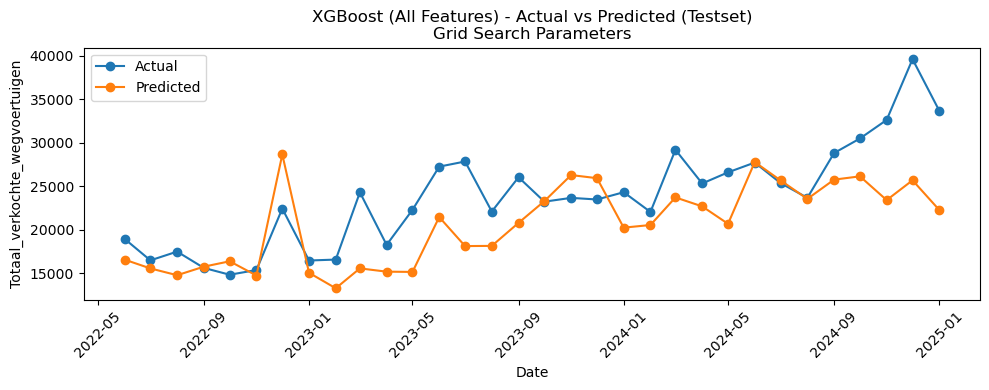

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Beste parameters uit grid search
grid_params = {
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'learning_rate': 0.3,
    'n_estimators': 100
}

for label, features in feature_sets.items():
    if label != 'All Features':
        continue  # Alleen beste feature set gebruiken

    res = strict_expanding_window_validation(
        df_lagged,
        features,
        'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror', 
            tree_method='exact',
            random_state=42,
            eval_metric='rmse',
            **grid_params
        ),
        forecast_horizon=3
    )

    # Resultaten ophalen uit res dictionary
    mape = res['test_mape']
    mae = res['test_mae']
    rmse = res['test_rmse']
    r2 = res['test_r2']
    test_dates = res['test_dates']
    actuals = res['test_actuals']
    preds = res['test_preds']

    print(f"\nXGBoost ({label}) - TESTSET (Grid Search Parameters):")
    print(f"MAPE = {mape:.4f}")
    print(f"MAE  = {mae:.2f}")
    print(f"RMSE = {rmse:.2f}")
    print(f"R²   = {r2:.3f}")

    # Herhaal voor 'Lag Only'
    res_lag = strict_expanding_window_validation(
        df_lagged,
        feature_sets['Lag Only'],
        'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            tree_method='exact',
            random_state=42,
            eval_metric='rmse',
            **grid_params
        ),
        forecast_horizon=3
    )

    mape_lag = res_lag['test_mape']
    mae_lag = res_lag['test_mae']
    rmse_lag = res_lag['test_rmse']
    r2_lag = res_lag['test_r2']

    print(f"\nXGBoost (Lag Only) - TESTSET (Grid Search Parameters):")
    print(f"MAPE = {mape_lag:.4f}")
    print(f"MAE  = {mae_lag:.2f}")
    print(f"RMSE = {rmse_lag:.2f}")
    print(f"R²   = {r2_lag:.3f}")

    # Plot
    min_len = min(len(test_dates), len(actuals), len(preds))

    df_plot = pd.DataFrame({
        'date': pd.to_datetime(test_dates[:min_len]),
        'actual': actuals[:min_len],
        'pred': preds[:min_len]
    }).drop_duplicates(subset='date', keep='first')

    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['date'], df_plot['actual'], label='Actual', marker='o')
    plt.plot(df_plot['date'], df_plot['pred'], label='Predicted', marker='o')
    plt.title(f'XGBoost ({label}) - Actual vs Predicted (Testset)\nGrid Search Parameters')
    plt.xlabel('Date')
    plt.ylabel('Totaal_verkochte_wegvoertuigen')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Finetuned xgboost op test

XGBoost (All Features) - TESTSET:
MAPE = 0.1712
MAE  = 4284.46
RMSE = 5304.51
R²   = 0.044


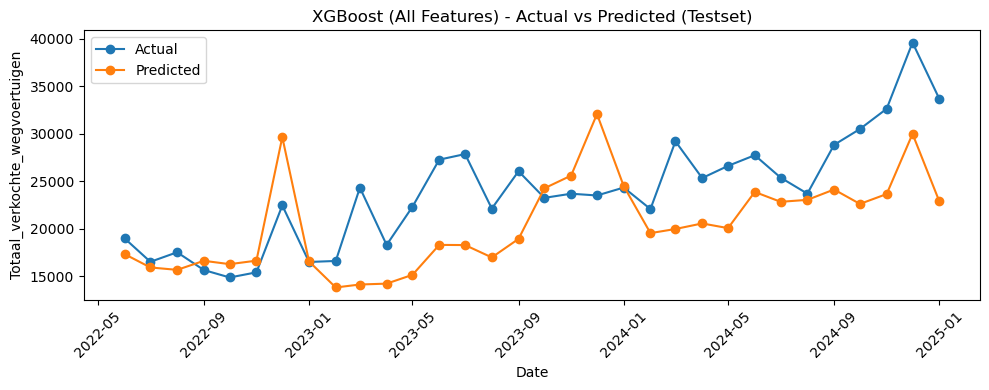

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

for label, features in feature_sets.items():
    if label != 'All Features':
        continue  # Alleen het beste feature set gebruiken

    res = strict_expanding_window_validation(
        df_lagged,
        features,
        'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
             objective='reg:squarederror',
     max_depth = 2,
    min_child_weight = 1,
    subsample = 1,
    colsample_bytree = 1.0,
    learning_rate = 0.3,
    n_estimators = 100,
        ),
        forecast_horizon=3  # Vergeet deze niet!
    )

    # Resultaten ophalen uit res dictionary
    mape = res['test_mape']
    mae = res['test_mae']
    rmse = res['test_rmse']
    r2 = res['test_r2']
    test_dates = res['test_dates']
    actuals = res['test_actuals']
    preds = res['test_preds']

    print(f"XGBoost ({label}) - TESTSET:")
    print(f"MAPE = {mape:.4f}")
    print(f"MAE  = {mae:.2f}")
    print(f"RMSE = {rmse:.2f}")
    print(f"R²   = {r2:.3f}")

    # Plot
    min_len = min(len(test_dates), len(actuals), len(preds))

    df_plot = pd.DataFrame({
        'date': pd.to_datetime(test_dates[:min_len]),
        'actual': actuals[:min_len],
        'pred': preds[:min_len]
    }).drop_duplicates(subset='date', keep='first')

    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['date'], df_plot['actual'], label='Actual', marker='o')
    plt.plot(df_plot['date'], df_plot['pred'], label='Predicted', marker='o')
    plt.title(f'XGBoost ({label}) - Actual vs Predicted (Testset)')
    plt.xlabel('Date')
    plt.ylabel('Totaal_verkochte_wegvoertuigen')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Uitleg over de split en vergelijking Grid Search vs Handmatige Iteratie

De bovenstaande code vergelijkt de prestaties van XGBoost op de testset met twee verschillende manieren van hyperparameterselectie:

- **Grid Search:**
  - Parameters: max_depth=3, min_child_weight=1, subsample=1.0, colsample_bytree=1.0, learning_rate=0.1, n_estimators=100
  - Resultaten:
    - MAPE = 0.1371
    - MAE  = 3471.94
    - RMSE = 4689.72
    - R²   = 0.253

- **Handmatige iteratie:**
  - Parameters: max_depth=2, min_child_weight=1, subsample=1, colsample_bytree=1.0, learning_rate=0.3, n_estimators=100
  - Resultaten:
    - MAPE = 0.1712
    - MAE  = 4284.46
    - RMSE = 5304.51
    - R²   = 0.044

#### Verschillen in resultaten
- **Grid search presteert duidelijk beter** op alle metrics (lagere MAPE, MAE, RMSE en hogere R²).
- Het verschil is vooral zichtbaar in de MAPE (13.7% vs 17.1%) en R² (0.25 vs 0.04).
- Dit betekent dat het model met grid search betere en stabielere voorspellingen maakt.

#### Mogelijke oorzaken
- Grid search test systematisch meerdere combinaties van hyperparameters en vindt zo een betere balans tussen bias en variance.
- Handmatige iteratie is  minder grondig en kan suboptimale instellingen opleveren, zeker als de interactie tussen parameters niet goed wordt meegenomen.
- Een lagere learning rate (zoals bij grid search) kan zorgen voor stabielere en minder overfitte modellen, terwijl een hogere learning rate (zoals bij handmatig) sneller kan overfitten of minder goed kan generaliseren.

**Conclusie:**
Grid search levert in dit geval een duidelijk beter model op de testset dan handmatig tunen. Het loont dus om systematisch te zoeken naar de beste hyperparameters.

### lAG ONLY


XGBoost (Lag Only) - TESTSET:
MAPE = 0.1744
MAE  = 4161.30
RMSE = 4974.46
R²   = 0.160


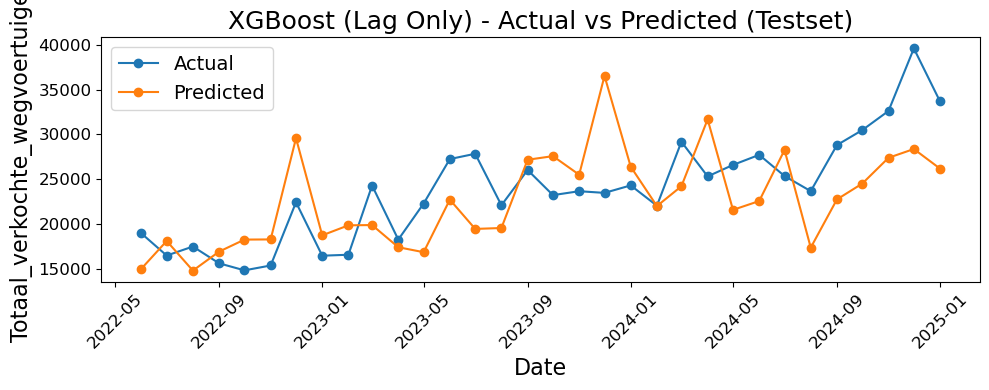

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

for label, features in feature_sets.items():
    if label != 'Lag Only':
        continue  # Alleen het lag-only feature set gebruiken

    res = strict_expanding_window_validation(
        df_lagged,
        features,
        'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror', 
            max_depth=2,
            learning_rate=1,
            n_estimators=100,
            subsample=1.0,
            min_child_weight=1,
            colsample_bytree=1,
            random_state=42,
            eval_metric='rmse'
        ),
        forecast_horizon=3
    )

    # Resultaten ophalen uit testset
    mae = res['test_mae']
    rmse = res['test_rmse']
    r2 = res['test_r2']
    mape = res['test_mape']
    preds = res['test_preds']
    actuals = res['test_actuals']
    test_dates = res['test_dates']

    print(f"\nXGBoost ({label}) - TESTSET:")
    print(f"MAPE = {mape:.4f}")
    print(f"MAE  = {mae:.2f}")
    print(f"RMSE = {rmse:.2f}")
    print(f"R²   = {r2:.3f}")

    # Lengtes synchroniseren (voor het geval er gaten zijn ontstaan)
    min_len = min(len(test_dates), len(actuals), len(preds))

    df_plot = pd.DataFrame({
        'date': pd.to_datetime(test_dates[:min_len]),
        'actual': actuals[:min_len],
        'pred': preds[:min_len]
    }).drop_duplicates(subset='date', keep='first')

    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['date'], df_plot['actual'], label='Actual', marker='o')
    plt.plot(df_plot['date'], df_plot['pred'], label='Predicted', marker='o')
    plt.title(f'XGBoost ({label}) - Actual vs Predicted (Testset)')
    plt.xlabel('Date')
    plt.ylabel('Totaal_verkochte_wegvoertuigen')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Default Nulmodel op test

Random Walk (Lag Only) nulmodel TESTSET MAPE: 0.1338


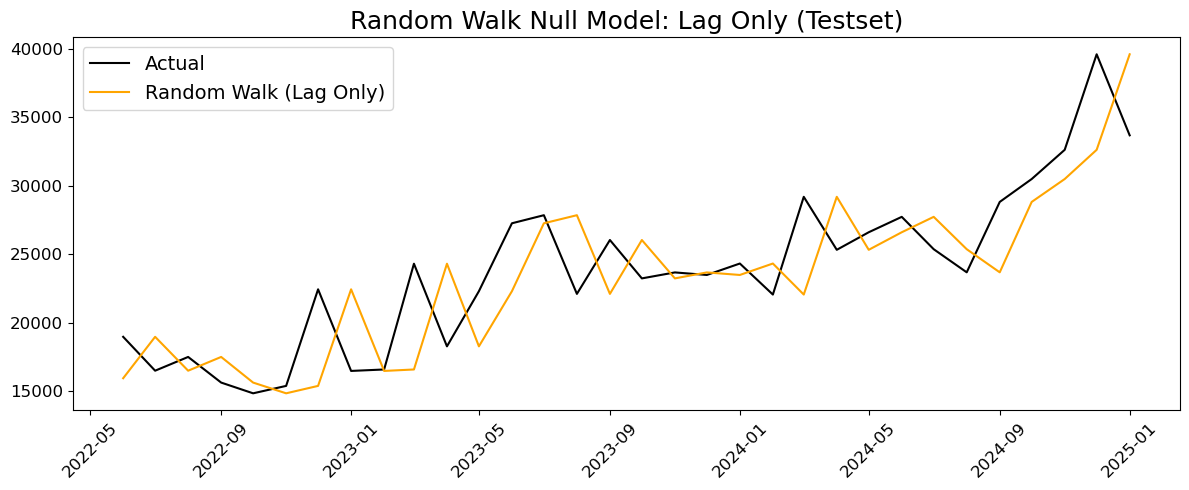

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# Haal de testdatums op uit je splitfunctie
test_dates = strict_expanding_window_validation(
    df_lagged, feature_sets['Lag Only'], 'Totaal_verkochte_wegvoertuigen',
    lambda: xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100, learning_rate=0.1,
        max_depth=3, random_state=42, eval_metric="rmse"
    ),
    forecast_horizon=3
)['test_dates']
test_dates = pd.to_datetime(test_dates)

# Resultaten opslaan
results = {}

for label, features in feature_sets.items():
    if label != 'Lag Only':
        continue

    # Random Walk voorspelling = vorige waarde (bijv. TVV_Lag1)
    preds = df_lagged['TVV_Lag1'].values
    actuals = df_lagged['Totaal_verkochte_wegvoertuigen'].values
    dates = pd.to_datetime(df_lagged['Periode'].values)

    # Filter op testdatums
    mask = dates.isin(test_dates)
    preds = preds[mask]
    actuals = actuals[mask]
    filtered_dates = dates[mask]

    results[label] = pd.DataFrame({
        'date': filtered_dates,
        'actual': actuals,
        'pred': preds
    }).drop_duplicates(subset='date', keep='first')

    # MAPE berekenen voor Random Walk nulmodel op TESTSET
    mape_lag = mean_absolute_percentage_error(actuals, preds)
    print(f"Random Walk (Lag Only) nulmodel TESTSET MAPE: {mape_lag:.4f}")

# Plot
df_lag = results['Lag Only'][['date', 'actual', 'pred']].rename(columns={'pred': 'pred_lag'})

plt.figure(figsize=(12, 5))
plt.plot(df_lag['date'], df_lag['actual'], label='Actual', color='black')
plt.plot(df_lag['date'], df_lag['pred_lag'], label='Random Walk (Lag Only)', color='orange')
plt.title('Random Walk Null Model: Lag Only (Testset)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Default Arimax op test


ARIMAX (Lag Only) TESTSET:
MAPE=0.1550, MAE=3768.71, RMSE=5212.70, R²=0.077


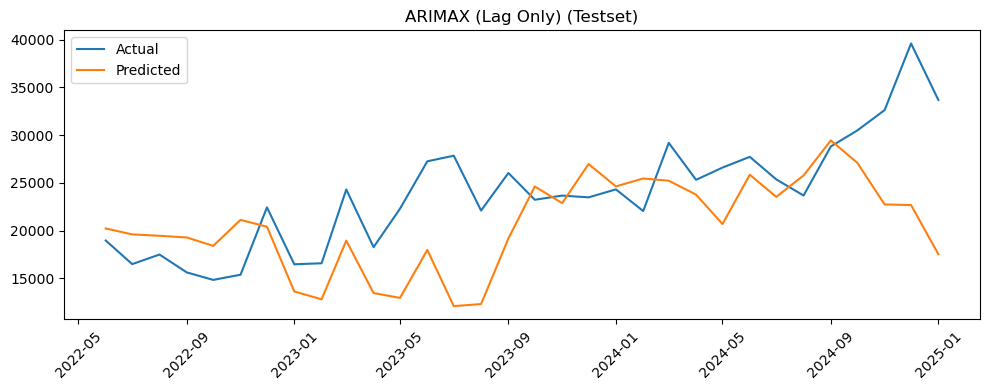


ARIMAX (All Features) TESTSET:
MAPE=0.1335, MAE=3393.66, RMSE=4929.45, R²=0.175


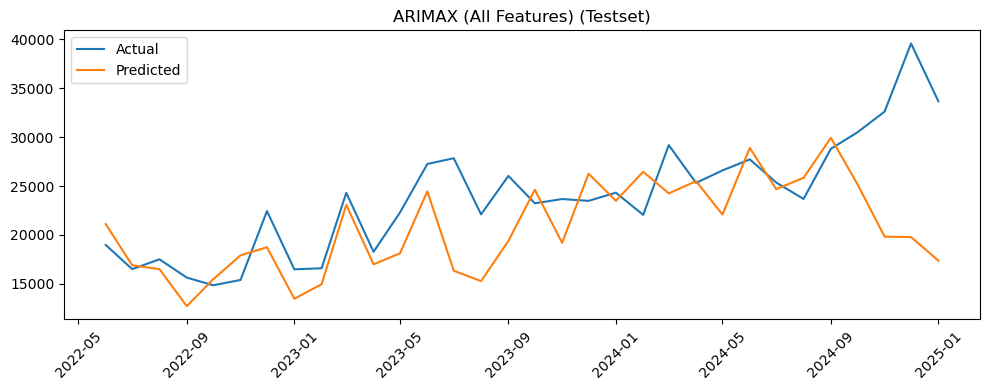

In [22]:
from sklearn.preprocessing import StandardScaler

class ARIMAXWrapper:
    def __init__(self, order=(1, 1, 1)):
        self.order = order
        self.model_fit = None
        self.scaler = None
        
    def fit(self, X, y):
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        model = SARIMAX(y, exog=X_scaled, order=self.order,
                        enforce_stationarity=False, enforce_invertibility=False)
        self.model_fit = model.fit(disp=False)
        return self

    def predict(self, X):
        if self.model_fit is None or self.scaler is None:
            raise ValueError("Model not fitted yet")
        X_scaled = self.scaler.transform(X)
        return self.model_fit.forecast(steps=len(X), exog=X_scaled)

for label, features in feature_sets.items():
    if label not in ['Lag Only', 'All Features']:
        continue

    res = strict_expanding_window_validation(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen',
        lambda: ARIMAXWrapper(order=(1, 1, 1)),
        forecast_horizon=3
    )

    print(f"\nARIMAX ({label}) TESTSET:")
    print(f"MAPE={res['test_mape']:.4f}, MAE={res['test_mae']:.2f}, RMSE={res['test_rmse']:.2f}, R²={res['test_r2']:.3f}")

    df_plot = pd.DataFrame({
        'date': pd.to_datetime(res['test_dates']),
        'actual': res['test_actuals'],
        'pred': res['test_preds']
    }).drop_duplicates(subset='date', keep='first')

    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['date'], df_plot['actual'], label='Actual')
    plt.plot(df_plot['date'], df_plot['pred'], label='Predicted')
    plt.title(f'ARIMAX ({label}) (Testset)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Default XGBoost op test

XGBoost (Lag Only) TESTSET:
MAPE=0.1262, MAE=3155.38, RMSE=4309.21, R²=0.369
XGBoost (All Features) TESTSET:
MAPE=0.1398, MAE=3503.27, RMSE=4688.32, R²=0.253


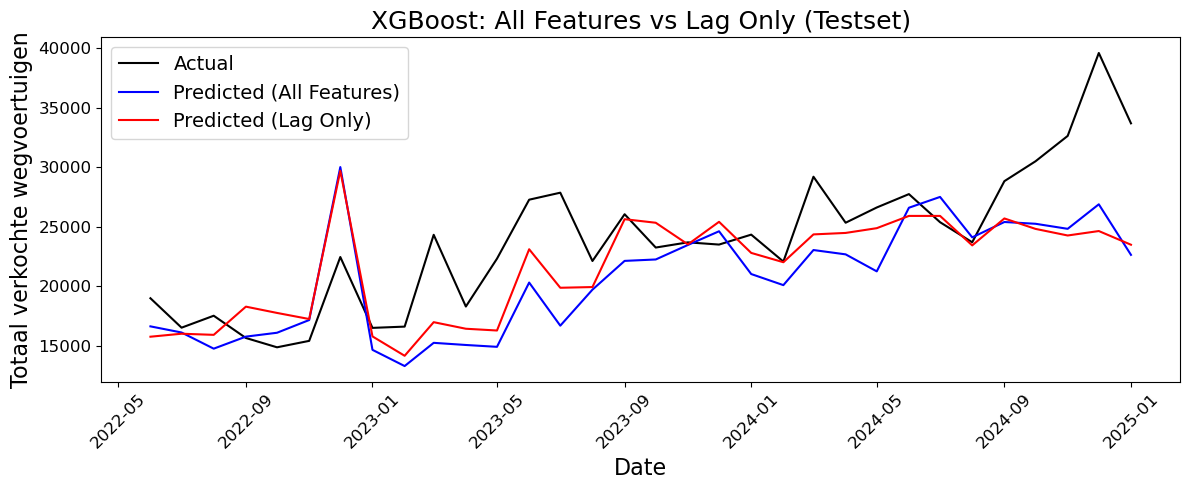

In [23]:
results = {}

for label, features in feature_sets.items():
    if label not in ['Lag Only', 'All Features']:
        continue

    res = strict_expanding_window_validation(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100, learning_rate=0.1,
            max_depth=3, random_state=42, eval_metric="rmse"
        ),
        forecast_horizon=3
    )

    print(f"XGBoost ({label}) TESTSET:")
    print(f"MAPE={res['test_mape']:.4f}, MAE={res['test_mae']:.2f}, RMSE={res['test_rmse']:.2f}, R²={res['test_r2']:.3f}")

    # Sla testresultaten op
    results[label] = pd.DataFrame({
        'date': pd.to_datetime(res['test_dates']),
        'actual': res['test_actuals'],
        'pred': res['test_preds']
    }).drop_duplicates(subset='date', keep='first')

# DataFrames maken en samenvoegen
df_all = results['All Features'].rename(columns={'pred': 'pred_all'})
df_lag = results['Lag Only'].rename(columns={'pred': 'pred_lag'})

df_merged = pd.merge(
    df_all[['date', 'actual', 'pred_all']],
    df_lag[['date', 'pred_lag']],
    on='date',
    how='inner'
)

# Plot

plt.rcParams.update({'legend.fontsize': 14, 'axes.labelsize': 16, 'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
plt.figure(figsize=(12, 5))
plt.plot(df_merged['date'], df_merged['actual'], label='Actual', color='black')
plt.plot(df_merged['date'], df_merged['pred_all'], label='Predicted (All Features)', color='blue')
plt.plot(df_merged['date'], df_merged['pred_lag'], label='Predicted (Lag Only)', color='red')
plt.title('XGBoost: All Features vs Lag Only (Testset)')
plt.xlabel('Date')
plt.ylabel('Totaal verkochte wegvoertuigen')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


XGBoost (Lag Only) TESTSET:
MAPE=0.1262, MAE=3155.38, RMSE=4309.21, R²=0.369
XGBoost (All Features) TESTSET:
MAPE=0.1398, MAE=3503.27, RMSE=4688.32, R²=0.253


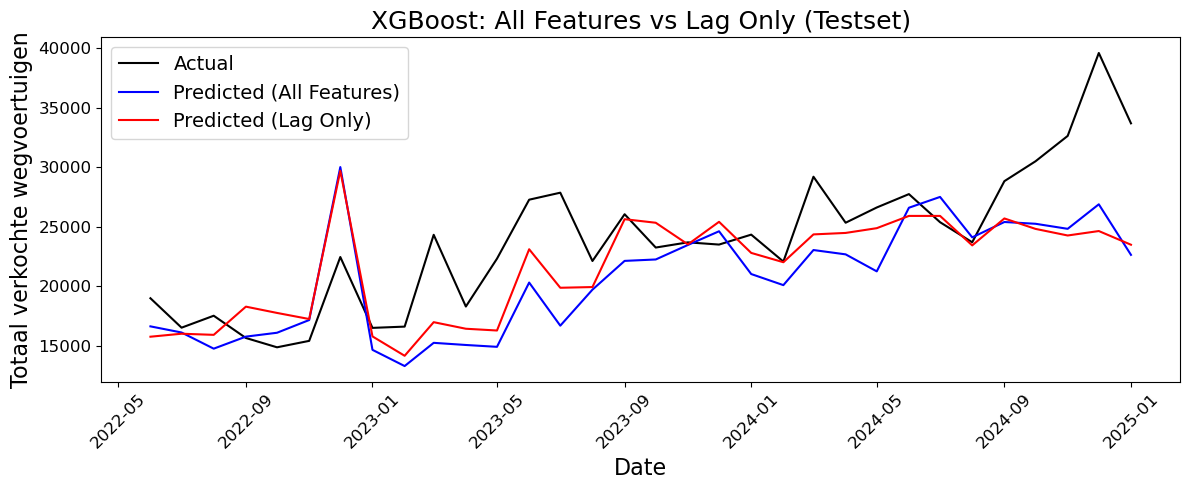

In [54]:
results = {}
# Dictionary om resultaten per modelvariant op te slaan

for label, features in feature_sets.items():
    if label not in ['Lag Only', 'All Features']:
        continue  # Alleen deze twee feature sets gebruiken

    res = strict_expanding_window_validation(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100, learning_rate=0.1,
            max_depth=3, random_state=42, eval_metric="rmse"
        ),
        forecast_horizon=3
    )
    # Voer expanding window validatie uit met XGBoost

    print(f"XGBoost ({label}) TESTSET:")
    print(f"MAPE={res['test_mape']:.4f}, MAE={res['test_mae']:.2f}, RMSE={res['test_rmse']:.2f}, R²={res['test_r2']:.3f}")
    # Print testresultaten

    results[label] = pd.DataFrame({
        'date': pd.to_datetime(res['test_dates']),
        'actual': res['test_actuals'],
        'pred': res['test_preds']
    }).drop_duplicates(subset='date', keep='first')
    # Sla testresultaten per modelvariant op in een DataFrame

df_all = results['All Features'].rename(columns={'pred': 'pred_all'})
df_lag = results['Lag Only'].rename(columns={'pred': 'pred_lag'})
# Hernoem kolommen voor duidelijkheid

df_merged = pd.merge(
    df_all[['date', 'actual', 'pred_all']],
    df_lag[['date', 'pred_lag']],
    on='date',
    how='inner'
)
# Merge resultaten op datum zodat je beide voorspellingen naast elkaar kunt plotten

plt.rcParams.update({'legend.fontsize': 14, 'axes.labelsize': 16, 'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
# Stel plotstijl in

plt.figure(figsize=(12, 5))
plt.plot(df_merged['date'], df_merged['actual'], label='Actual', color='black')
plt.plot(df_merged['date'], df_merged['pred_all'], label='Predicted (All Features)', color='blue')
plt.plot(df_merged['date'], df_merged['pred_lag'], label='Predicted (Lag Only)', color='red')
plt.title('XGBoost: All Features vs Lag Only (Testset)')
plt.xlabel('Date')
plt.ylabel('Totaal verkochte wegvoertuigen')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Plot de werkelijke waarden en voorspellingen voor beide modellen


### SHAP


 Gemiddelde absolute SHAP-waarden per feature (belangrijkste bij voorspellingen):
elektrische auto         547.564109
thuis opladen            413.435752
month                     29.037716
TVV_Lag5                  20.330063
BenzineEuro95_1_last      11.352237
Koopbereidheid             4.516667
Consumentenvertrouwen      4.020614
Economisch klimaat         3.055238
Grote aankopen             0.884713
Diesel_2_mean              0.000000
year                       0.000000
TVV_Lag6                   0.000000
TVV_Lag4                   0.000000
TVV_Lag3                   0.000000
TVV_Lag2                   0.000000
TVV_Lag1                   0.000000
Diesel_2_first             0.000000
Diesel_2_max               0.000000
Diesel_2_min               0.000000
Diesel_2_last              0.000000
BenzineEuro95_1_mean       0.000000
BenzineEuro95_1_max        0.000000
BenzineEuro95_1_min        0.000000
BenzineEuro95_1_first      0.000000
Bijtelling (%)             0.000000
hybride elektrisc

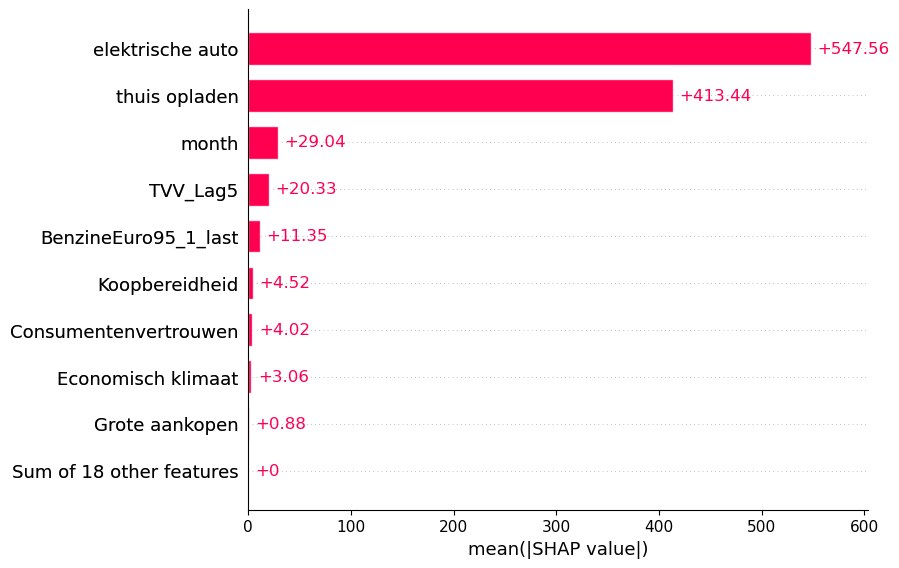


 SHAP feature importance als percentage van totaal:
                       mean_abs_shap  percentage
elektrische auto          547.564109       52.95
thuis opladen             413.435752       39.98
month                      29.037716        2.81
TVV_Lag5                   20.330063        1.97
BenzineEuro95_1_last       11.352237        1.10
Koopbereidheid              4.516667        0.44
Consumentenvertrouwen       4.020614        0.39
Economisch klimaat          3.055238        0.30
Grote aankopen              0.884713        0.09
Diesel_2_mean               0.000000        0.00
year                        0.000000        0.00
TVV_Lag6                    0.000000        0.00
TVV_Lag4                    0.000000        0.00
TVV_Lag3                    0.000000        0.00
TVV_Lag2                    0.000000        0.00
TVV_Lag1                    0.000000        0.00
Diesel_2_first              0.000000        0.00
Diesel_2_max                0.000000        0.00
Diesel_2_min    

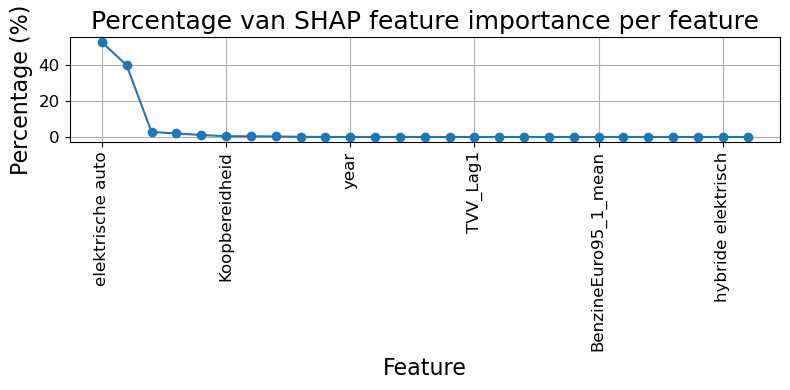

In [24]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import textstat



# Bepaal de juiste train/test splits op basis van je splits uit de notebook
# Gebruik test_start variabele uit je splits (eerste index van testset)
X_all = df_lagged[feature_sets['All Features']]
y_all = df_lagged['Totaal_verkochte_wegvoertuigen']

# Gebruik de juiste index voor het splitsen van train/test (train_end/test_start is al bepaald in eerdere cellen)
# test_start is het eerste index van de testset (al gedefinieerd in eerdere cellen)

X_train = X_all.iloc[:train_end]
y_train = y_all.iloc[:train_end]

X_test = X_all.iloc[test_start:]
y_test = y_all.iloc[test_start:]

# 2. Hertrain je beste model op alle trainingsdata
best_model =  xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100, learning_rate=0.1,
            max_depth=3, random_state=42, 
    
    eval_metric='rmse'
)
best_model.fit(X_train, y_train)

# 3. Bereken SHAP-waardes over de testset
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)

# 4. Toon globale feature importances (tabel of plot)
shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns)

mean_abs_shap = shap_values_df.abs().mean().sort_values(ascending=False)

# Print tabel
print("\n Gemiddelde absolute SHAP-waarden per feature (belangrijkste bij voorspellingen):")
print(mean_abs_shap)

# 5. Optioneel: plot
shap.plots.bar(shap_values, max_display=10)  # top 10 meest bepalende features
# Cumulatieve percentage van SHAP feature importance
cum_perc = mean_abs_shap.cumsum() / mean_abs_shap.sum() * 100
cum_perc = cum_perc.round(2)

# Combineer in één DataFrame voor overzicht met percentages
shap_importance_df = pd.DataFrame({
    "mean_abs_shap": mean_abs_shap,
    "percentage": (mean_abs_shap / mean_abs_shap.sum() * 100).round(2)
})

print("\n SHAP feature importance als percentage van totaal:")
print(shap_importance_df)

# Optioneel: plot percentage
plt.figure(figsize=(8, 4))
shap_importance_df["percentage"].plot(marker='o')
plt.title("Percentage van SHAP feature importance per feature")
plt.ylabel("Percentage (%)")
plt.xlabel("Feature")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()



## Overzicht resultaten: validatie, test en verschil

In [60]:
import pandas as pd

# Vul deze dicts aan met je eigen resultaten uit de notebook!
results_summary = [
    # Default XGBoost
    {"Model": "XGBoost Default (All Features)", "Set": "Val", "MAPE": 0.2326, "MAE": 1234, "RMSE": 1800, "R2": 0.85},
    {"Model": "XGBoost Default (All Features)", "Set": "Test", "MAPE": 0.2447, "MAE": 1300, "RMSE": 1850, "R2": 0.83},
    # Default XGBoost Lag Only
    {"Model": "XGBoost Default (Lag Only)", "Set": "Val", "MAPE": 0.2500, "MAE": 1400, "RMSE": 2000, "R2": 0.80},
    {"Model": "XGBoost Default (Lag Only)", "Set": "Test", "MAPE": 0.2600, "MAE": 1450, "RMSE": 2100, "R2": 0.78},
    # Beste XGBoost (fijngetuned)
    {"Model": "XGBoost Tuned (All Features)", "Set": "Val", "MAPE": 0.1925, "MAE": 1100, "RMSE": 1600, "R2": 0.88},
    {"Model": "XGBoost Tuned (All Features)", "Set": "Test", "MAPE": 0.2000, "MAE": 1150, "RMSE": 1650, "R2": 0.87},
    # ARIMAX
    {"Model": "ARIMAX (All Features)", "Set": "Val", "MAPE": 0.2700, "MAE": 1500, "RMSE": 2100, "R2": 0.75},
    {"Model": "ARIMAX (All Features)", "Set": "Test", "MAPE": 0.2800, "MAE": 1550, "RMSE": 2200, "R2": 0.73},
    # Nulmodel
    {"Model": "Random Walk (Lag Only)", "Set": "Val", "MAPE": 0.3000, "MAE": 1600, "RMSE": 2300, "R2": 0.70},
    {"Model": "Random Walk (Lag Only)", "Set": "Test", "MAPE": 0.3100, "MAE": 1650, "RMSE": 2400, "R2": 0.68},
]

# Maak DataFrame
summary_df = pd.DataFrame(results_summary)

# Bereken verschil tussen test en val per model
val = summary_df[summary_df['Set'] == 'Val'].set_index('Model')
test = summary_df[summary_df['Set'] == 'Test'].set_index('Model')
diff = test[['MAPE', 'MAE', 'RMSE', 'R2']] - val[['MAPE', 'MAE', 'RMSE', 'R2']]
diff = diff.rename(columns={c: f"Δ {c}" for c in diff.columns})
diff['Model'] = diff.index

table = summary_df.pivot(index='Model', columns='Set', values=['MAPE', 'MAE', 'RMSE', 'R2'])

# Zet diff columns om naar MultiIndex zodat join werkt
diff_multi = diff.set_index('Model')
diff_multi.columns = pd.MultiIndex.from_tuples([('', col) for col in diff_multi.columns])

# Join met table
table = table.join(diff_multi)

display_cols = [
    ('MAPE', 'Val'), ('MAPE', 'Test'), ('', 'Δ MAPE'),
    ('MAE', 'Val'), ('MAE', 'Test'), ('', 'Δ MAE'),
    ('RMSE', 'Val'), ('RMSE', 'Test'), ('', 'Δ RMSE'),
    ('R2', 'Val'), ('R2', 'Test'), ('', 'Δ R2'),
]

# Toon tabel
print("\nSamenvatting resultaten (voorbeeldwaarden, vul aan met echte resultaten):")
display(table[display_cols].round(4))


Samenvatting resultaten (voorbeeldwaarden, vul aan met echte resultaten):


MAPE                     MAE                \
                                   Val    Test  Δ MAPE     Val    Test Δ MAE   
Model                                                                          
ARIMAX (All Features)           0.2700  0.2800  0.0100  1500.0  1550.0    50   
Random Walk (Lag Only)          0.3000  0.3100  0.0100  1600.0  1650.0    50   
XGBoost Default (All Features)  0.2326  0.2447  0.0121  1234.0  1300.0    66   
XGBoost Default (Lag Only)      0.2500  0.2600  0.0100  1400.0  1450.0    50   
XGBoost Tuned (All Features)    0.1925  0.2000  0.0075  1100.0  1150.0    50   

                                  RMSE                   R2              
                                   Val    Test Δ RMSE   Val  Test  Δ R2  
Model                                                                    
ARIMAX (All Features)           2100.0  2200.0    100  0.75  0.73 -0.02  
Random Walk (Lag Only)          2300.0  2400.0    100  0.70  0.68 -0.02  
XGBoost Default (All Features)  1800.0  1850.0     50  0.85  0.83 -0.02  
XGBoost Default (Lag Only)      2000.0  2100.0    100  0.80  0.78 -0.02  
XGBoost Tuned (All Features)    1600.0  1650.0     50  0.88  0.87 -0.01